In [2]:
import pandas as pd
import numpy as np

data = pd.read_excel(r"C:\Users\ASUS\Downloads\V5_Capstone_Final_Dataset.xlsx")
data.columns
print(data.dtypes) 

import pandas as pd

# Load the Excel file
data = pd.read_excel(r"C:\Users\ASUS\Downloads\V5_Capstone_Final_Dataset.xlsx")


REF_DATE                                                            int64
GEO                                                                object
Total, food services and drinking places -revenue in thousands      int64
Age group                                                          object
Actual Population                                                   int64
Sex                                                                object
Diabetes                                                            int64
High Blood Pressure                                                 int64
Coffee&Tea                                                        float64
Fish                                                              float64
Bakery products                                                   float64
Butter                                                            float64
Cereal products (excluding baby food)                             float64
Cheese                                

Years in dataset: 2015 to 2022
Latest year in dataset: 2022

🎯 Running Diabetes Model Comparison...

✅ XGBoost - Diabetes Metrics:
  - MSE: 3916.3871
  - RMSE: 62.5810
  - MAE: 44.8304
  - R2 Score: 0.1134

✅ Random Forest - Diabetes Metrics:
  - MSE: 4110.0284
  - RMSE: 64.1095
  - MAE: 48.8133
  - R2 Score: 0.0696

🏆 Best model for Diabetes: XGBoost

🎯 Running HBP Model Comparison...

✅ XGBoost - HBP Metrics:
  - MSE: 16944.5650
  - RMSE: 130.1713
  - MAE: 89.3748
  - R2 Score: 0.3606

✅ Random Forest - HBP Metrics:
  - MSE: 18083.0481
  - RMSE: 134.4732
  - MAE: 102.2976
  - R2 Score: 0.3176

🏆 Best model for HBP: XGBoost

🔄 Training final models on complete dataset...

📈 Forecasting for 2023-2028...

🔮 Forecasting Diabetes using: XGBoost

🔮 Forecasting HBP using: XGBoost
Forecast years: [2023, 2024, 2025, 2026, 2027, 2028]

📊 Diabetes Forecast for 2023-2028:
    Year   Forecast
0  2023  40.367863
1  2024  37.737095
2  2025  37.737095
3  2026  37.356133
4  2027  37.356133
5  2028  3

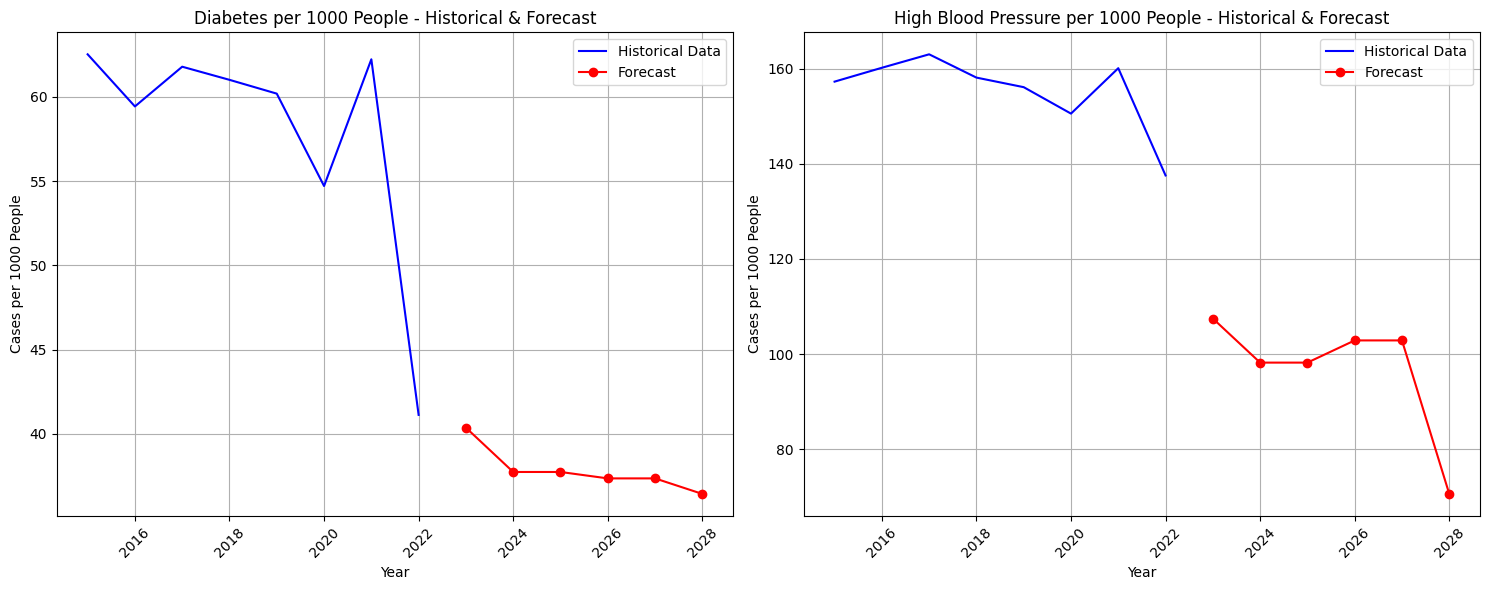

In [3]:
# Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Load and Preprocess Data
data = pd.read_excel(r"C:\Users\ASUS\Downloads\V5_Capstone_Final_Dataset.xlsx")

# Since REF_DATE contains only years, convert directly to integer years
data['Year'] = data['REF_DATE']  # Directly use the values as years

# Verify year values
print(f"Years in dataset: {data['Year'].min()} to {data['Year'].max()}")

# Sort by year
data = data.sort_values('Year')

# Get the latest year in the dataset for future forecasting
latest_year = data['Year'].max()
print(f"Latest year in dataset: {latest_year}")

# Encode categorical variables
label_encoders = {}
categorical_features = ['GEO', 'Age group', 'Sex']
for col in categorical_features:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])
    label_encoders[col] = le

# Define target variables
data['Diabetes_per_capita'] = data['Diabetes'] / data['Actual Population'] * 1000
data['HBP_per_capita'] = data['High Blood Pressure'] / data['Actual Population'] * 1000

# Create a dummy month feature (since we only have yearly data)
data['Month'] = 6  # Mid-year as representative

# Correlation Analysis
correlation_df = data.corr(numeric_only=True)
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_df[['Diabetes_per_capita', 'HBP_per_capita']].sort_values(by='Diabetes_per_capita', ascending=False), annot=True, cmap='coolwarm')
plt.title('Correlation Analysis: Food Costs vs. Diabetes and HBP (per 1000 people)')
plt.savefig('correlation_heatmap.png')
plt.close()

# Feature Selection Based on Correlation
selected_features = [
    'Sugar and confectionery', 'Eggs', 'Bakery products', 'Butter', 'Dairy products',
    'Cheese', 'Fresh vegetables', 'Preserved fruit and fruit preparations', 'Fish',
    'Non-alcoholic beverages', 'Preserved vegetables and vegetable preparations', 'Actual Population',
    'Year', 'Month'  # Include time-based features
]

X = data[selected_features]
y_diabetes = data['Diabetes_per_capita']
y_hbp = data['HBP_per_capita']

# Split Data for Training and Testing
X_train_d, X_test_d, y_train_d, y_test_d = train_test_split(X, y_diabetes, test_size=0.2, random_state=42)
X_train_hbp, X_test_hbp, y_train_hbp, y_test_hbp = train_test_split(X, y_hbp, test_size=0.2, random_state=42)

# Standardize the data
scaler_d = StandardScaler()
scaler_hbp = StandardScaler()

X_train_d_scaled = scaler_d.fit_transform(X_train_d)
X_test_d_scaled = scaler_d.transform(X_test_d)
X_train_hbp_scaled = scaler_hbp.fit_transform(X_train_hbp)
X_test_hbp_scaled = scaler_hbp.transform(X_test_hbp)

# Model Evaluation Function
def evaluate_model(y_true, y_pred, model_name):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
   
    print(f"\n✅ {model_name} Metrics:")
    print(f"  - MSE: {mse:.4f}")
    print(f"  - RMSE: {rmse:.4f}")
    print(f"  - MAE: {mae:.4f}")
    print(f"  - R2 Score: {r2:.4f}")
    return mse, rmse, r2

# Calculate feature trends for forecasting
def calculate_feature_trends(data, selected_features):
    latest_feature_values = {}
    feature_trends = data.groupby('Year')[selected_features].mean()
   
    for feature in selected_features:
        if feature != 'Year' and feature != 'Month':
            # Calculate average annual growth rate
            feature_data = feature_trends[feature]
            if len(feature_data) > 2:
                annual_growth = (feature_data.iloc[-1] / feature_data.iloc[0]) ** (1/(len(feature_data)-1)) - 1
                latest_feature_values[feature] = {'value': feature_data.iloc[-1], 'growth': annual_growth}
            else:
                # Default to last value and small growth if not enough data
                latest_feature_values[feature] = {'value': feature_data.iloc[-1], 'growth': 0.02}
   
    return latest_feature_values

# Generate future data for forecasting (2023-2028)
def generate_future_data(latest_year, latest_feature_values, selected_features, start_year=2023, end_year=2028):
    future_data = []
   
    # For each future year - starting from start_year up to end_year
    for year in range(start_year, end_year + 1):
        # Calculate years since latest year in dataset
        years_forward = year - latest_year
       
        # For simplicity, we'll create one record per year
        future_record = {}
        future_record['Year'] = year
        future_record['Month'] = 6  # Mid-year as representative
       
        # Project each feature value based on its growth trend
        for feature, info in latest_feature_values.items():
            future_record[feature] = info['value'] * (1 + info['growth']) ** years_forward
           
        future_data.append(future_record)
   
    # Print to verify forecast years
    years = [record['Year'] for record in future_data]
    print(f"Forecast years: {years}")
   
    # Create dataframe with all necessary columns
    future_df = pd.DataFrame(future_data)
   
    # Ensure all selected features are present
    for feature in selected_features:
        if feature not in future_df.columns and feature not in ['Year', 'Month']:
            print(f"Warning: Adding missing feature '{feature}' with projected values")
            # Use a default growth rate if we don't have trend data
            base_value = data[feature].mean()
            future_df[feature] = [base_value * (1.02 ** (i+1)) for i in range(len(future_df))]
   
    return future_df

# ---- Model Comparison for Diabetes ----
print("\n🎯 Running Diabetes Model Comparison...")

# XGBoost for Diabetes
xgb_model_d = XGBRegressor(n_estimators=100, learning_rate=0.05, max_depth=6, random_state=42)
xgb_model_d.fit(X_train_d_scaled, y_train_d)
xgb_pred_d = xgb_model_d.predict(X_test_d_scaled)
xgb_mse_d, xgb_rmse_d, xgb_r2_d = evaluate_model(y_test_d, xgb_pred_d, "XGBoost - Diabetes")

# Random Forest for Diabetes
rf_model_d = RandomForestRegressor(n_estimators=100, max_depth=6, random_state=42)
rf_model_d.fit(X_train_d_scaled, y_train_d)
rf_pred_d = rf_model_d.predict(X_test_d_scaled)
rf_mse_d, rf_rmse_d, rf_r2_d = evaluate_model(y_test_d, rf_pred_d, "Random Forest - Diabetes")

# Determine best model for Diabetes
if xgb_mse_d < rf_mse_d:
    best_model_d = "XGBoost"
    print("\n🏆 Best model for Diabetes: XGBoost")
else:
    best_model_d = "Random Forest"
    print("\n🏆 Best model for Diabetes: Random Forest")

# ---- Model Comparison for HBP ----
print("\n🎯 Running HBP Model Comparison...")

# XGBoost for HBP
xgb_model_hbp = XGBRegressor(n_estimators=100, learning_rate=0.05, max_depth=6, random_state=42)
xgb_model_hbp.fit(X_train_hbp_scaled, y_train_hbp)
xgb_pred_hbp = xgb_model_hbp.predict(X_test_hbp_scaled)
xgb_mse_hbp, xgb_rmse_hbp, xgb_r2_hbp = evaluate_model(y_test_hbp, xgb_pred_hbp, "XGBoost - HBP")

# Random Forest for HBP
rf_model_hbp = RandomForestRegressor(n_estimators=100, max_depth=6, random_state=42)
rf_model_hbp.fit(X_train_hbp_scaled, y_train_hbp)
rf_pred_hbp = rf_model_hbp.predict(X_test_hbp_scaled)
rf_mse_hbp, rf_rmse_hbp, rf_r2_hbp = evaluate_model(y_test_hbp, rf_pred_hbp, "Random Forest - HBP")

# Determine best model for HBP
if xgb_mse_hbp < rf_mse_hbp:
    best_model_hbp = "XGBoost"
    print("\n🏆 Best model for HBP: XGBoost")
else:
    best_model_hbp = "Random Forest"
    print("\n🏆 Best model for HBP: Random Forest")

# Train models on the full dataset for forecasting
print("\n🔄 Training final models on complete dataset...")

# XGBoost for Diabetes (based on performance)
xgb_model_d_full = XGBRegressor(n_estimators=100, learning_rate=0.05, max_depth=6, random_state=42)
X_scaled_d_full = scaler_d.fit_transform(X)
xgb_model_d_full.fit(X_scaled_d_full, y_diabetes)

# XGBoost for HBP (based on performance)
xgb_model_hbp_full = XGBRegressor(n_estimators=100, learning_rate=0.05, max_depth=6, random_state=42)
X_scaled_hbp_full = scaler_hbp.fit_transform(X)
xgb_model_hbp_full.fit(X_scaled_hbp_full, y_hbp)

# ---- Forecast Next 6 Years (2023-2028) ----
print("\n📈 Forecasting for 2023-2028...")
print(f"\n🔮 Forecasting Diabetes using: XGBoost")
print(f"\n🔮 Forecasting HBP using: XGBoost")

# Calculate feature trends from historical data
latest_feature_values = calculate_feature_trends(data, [f for f in selected_features if f != 'Year' and f != 'Month'])

# Generate future data for 2023-2028
future_data = generate_future_data(latest_year, latest_feature_values, selected_features)

# Ensure all necessary features are present
for feature in selected_features:
    if feature not in future_data.columns:
        print(f"Error: Feature '{feature}' missing from future data")

# Scale the future data for predictions
future_data_scaled_d = scaler_d.transform(future_data[selected_features])
future_data_scaled_hbp = scaler_hbp.transform(future_data[selected_features])

# Make predictions
diabetes_predictions = xgb_model_d_full.predict(future_data_scaled_d)
hbp_predictions = xgb_model_hbp_full.predict(future_data_scaled_hbp)

# Create forecast dataframes
diabetes_forecast = pd.DataFrame({
    'Year': future_data['Year'],
    'Forecast': diabetes_predictions
})

hbp_forecast = pd.DataFrame({
    'Year': future_data['Year'],
    'Forecast': hbp_predictions
})

print("\n📊 Diabetes Forecast for 2023-2028:\n", diabetes_forecast)
print("\n📊 HBP Forecast for 2023-2028:\n", hbp_forecast)

# Visualize the forecasts
plt.figure(figsize=(15, 6))

# Diabetes historical data and forecast
plt.subplot(1, 2, 1)
historical_diabetes = data.groupby('Year')['Diabetes_per_capita'].mean()
plt.plot(historical_diabetes.index, historical_diabetes.values, 'b-', label='Historical Data')
plt.plot(diabetes_forecast['Year'], diabetes_forecast['Forecast'], 'ro-', label='Forecast')
plt.title('Diabetes per 1000 People - Historical & Forecast')
plt.xlabel('Year')
plt.ylabel('Cases per 1000 People')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)

# HBP historical data and forecast
plt.subplot(1, 2, 2)
historical_hbp = data.groupby('Year')['HBP_per_capita'].mean()
plt.plot(historical_hbp.index, historical_hbp.values, 'b-', label='Historical Data')
plt.plot(hbp_forecast['Year'], hbp_forecast['Forecast'], 'ro-', label='Forecast')
plt.title('High Blood Pressure per 1000 People - Historical & Forecast')
plt.xlabel('Year')
plt.ylabel('Cases per 1000 People')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)

plt.tight_layout()
plt.savefig('health_forecasts.png')
plt.show()

# Feature importance analysis
plt.figure(figsize=(10, 8))
feature_importance_diabetes = pd.DataFrame({
    'Feature': selected_features,
    'Importance': xgb_model_d_full.feature_importances_
})
feature_importance_diabetes = feature_importance_diabetes.sort_values('Importance', ascending=False)

plt.barh(feature_importance_diabetes['Feature'], feature_importance_diabetes['Importance'])
plt.xlabel('Importance')
plt.title('Feature Importance for Diabetes Prediction')
plt.tight_layout()
plt.savefig('diabetes_feature_importance.png')
plt.close()

plt.figure(figsize=(10, 8))
feature_importance_hbp = pd.DataFrame({
    'Feature': selected_features,
    'Importance': xgb_model_hbp_full.feature_importances_
})
feature_importance_hbp = feature_importance_hbp.sort_values('Importance', ascending=False)

plt.barh(feature_importance_hbp['Feature'], feature_importance_hbp['Importance'])
plt.xlabel('Importance')
plt.title('Feature Importance for HBP Prediction')
plt.tight_layout()
plt.savefig('hbp_feature_importance.png')
plt.close()



In [4]:
# Required Libraries
from sklearn.model_selection import GridSearchCV

# Define XGBoost model for tuning
from xgboost import XGBRegressor

# Parameter grid for tuning
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 6, 9],
    'subsample': [0.7, 0.8, 1.0]
}

# Instantiate GridSearchCV for Diabetes
xgb_d_grid = GridSearchCV(
    estimator=XGBRegressor(random_state=42),
    param_grid=param_grid,
    cv=3,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=2
)

# Fit the model on Diabetes
xgb_d_grid.fit(X_train_d_scaled, y_train_d)

# Best model for Diabetes
best_xgb_d = xgb_d_grid.best_estimator_
print(f"✅ Best XGBoost Parameters for Diabetes: {xgb_d_grid.best_params_}")

# Repeat for HBP
xgb_hbp_grid = GridSearchCV(
    estimator=XGBRegressor(random_state=42),
    param_grid=param_grid,
    cv=3,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=2
)

# Fit the model on HBP
xgb_hbp_grid.fit(X_train_hbp_scaled, y_train_hbp)

# Best model for HBP
best_xgb_hbp = xgb_hbp_grid.best_estimator_
print(f"✅ Best XGBoost Parameters for HBP: {xgb_hbp_grid.best_params_}")


Fitting 3 folds for each of 81 candidates, totalling 243 fits
✅ Best XGBoost Parameters for Diabetes: {'learning_rate': 0.01, 'max_depth': 9, 'n_estimators': 100, 'subsample': 1.0}
Fitting 3 folds for each of 81 candidates, totalling 243 fits
✅ Best XGBoost Parameters for HBP: {'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200, 'subsample': 1.0}


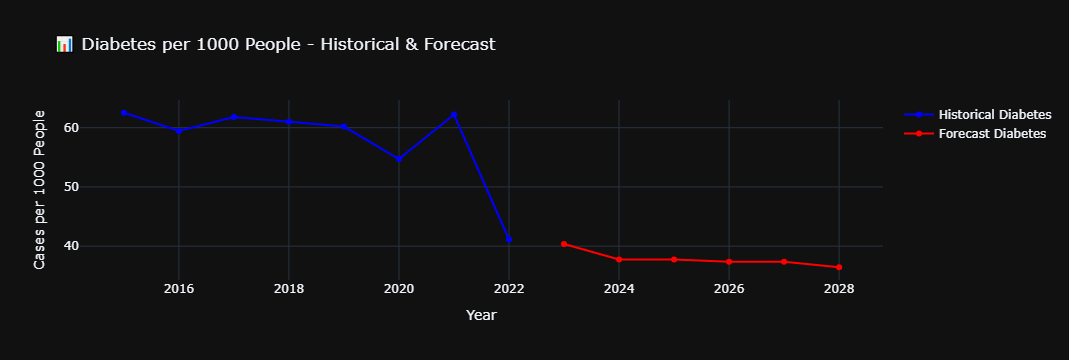

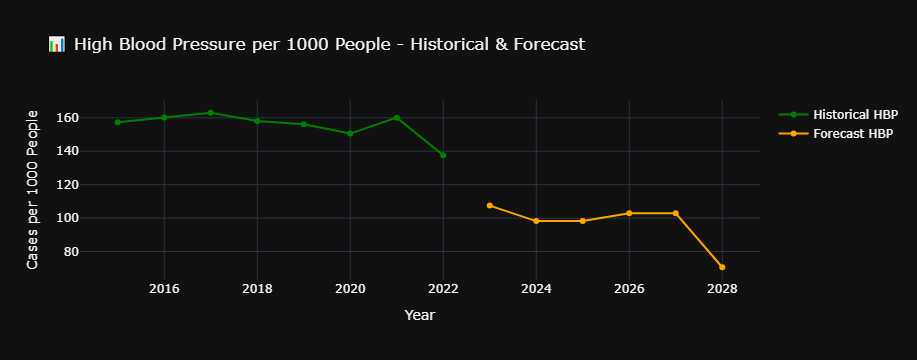

In [5]:
import plotly.graph_objects as go
import plotly.express as px

# Create interactive plot for Diabetes forecast
fig_d = go.Figure()

fig_d.add_trace(go.Scatter(
    x=historical_diabetes.index,
    y=historical_diabetes.values,
    mode='lines+markers',
    name='Historical Diabetes',
    line=dict(color='blue')
))

fig_d.add_trace(go.Scatter(
    x=diabetes_forecast['Year'],
    y=diabetes_forecast['Forecast'],
    mode='lines+markers',
    name='Forecast Diabetes',
    line=dict(color='red')
))

fig_d.update_layout(
    title="📊 Diabetes per 1000 People - Historical & Forecast",
    xaxis_title="Year",
    yaxis_title="Cases per 1000 People",
    template="plotly_dark"
)
fig_d.show()

# Create interactive plot for HBP forecast
fig_hbp = go.Figure()

fig_hbp.add_trace(go.Scatter(
    x=historical_hbp.index,
    y=historical_hbp.values,
    mode='lines+markers',
    name='Historical HBP',
    line=dict(color='green')
))

fig_hbp.add_trace(go.Scatter(
    x=hbp_forecast['Year'],
    y=hbp_forecast['Forecast'],
    mode='lines+markers',
    name='Forecast HBP',
    line=dict(color='orange')
))

fig_hbp.update_layout(
    title="📊 High Blood Pressure per 1000 People - Historical & Forecast",
    xaxis_title="Year",
    yaxis_title="Cases per 1000 People",
    template="plotly_dark"
)
fig_hbp.show()


In [6]:
# Add Inflation and Socioeconomic Impact on Food Cost
data['Inflation_Adjusted'] = data['Total, food services and drinking places -revenue in thousands'] * 1.03  # 3% inflation
data['Socioeconomic_Index'] = data['Actual Population'] * 0.005  # Proxy for income or awareness

# Recalculate Correlation with New Features
correlation_df_v2 = data.corr(numeric_only=True)
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_df_v2[['Diabetes_per_capita', 'HBP_per_capita']].sort_values(by='Diabetes_per_capita', ascending=False),
            annot=True, cmap='coolwarm')
plt.title('Correlation Analysis (Inflation & Socioeconomic Impact)')
plt.savefig('correlation_v2_heatmap.png')
plt.close()

# Add New Features to Selected Features for Future Forecasting
selected_features_v2 = selected_features + ['Inflation_Adjusted', 'Socioeconomic_Index']

# Future Forecast with Updated Features
latest_feature_values_v2 = calculate_feature_trends(data, selected_features_v2)
future_data_v2 = generate_future_data(latest_year, latest_feature_values_v2, selected_features_v2)


Forecast years: [2023, 2024, 2025, 2026, 2027, 2028]


In [16]:
print(X_train_d.columns.tolist())
print(X_train_hbp.columns.tolist())
print(future_data_v2.columns.tolist())


['Sugar and confectionery', 'Eggs', 'Bakery products', 'Butter', 'Dairy products', 'Cheese', 'Fresh vegetables', 'Preserved fruit and fruit preparations', 'Fish', 'Non-alcoholic beverages', 'Preserved vegetables and vegetable preparations', 'Actual Population', 'Year', 'Month']
['Sugar and confectionery', 'Eggs', 'Bakery products', 'Butter', 'Dairy products', 'Cheese', 'Fresh vegetables', 'Preserved fruit and fruit preparations', 'Fish', 'Non-alcoholic beverages', 'Preserved vegetables and vegetable preparations', 'Actual Population', 'Year', 'Month']
['Year', 'Month', 'Sugar and confectionery', 'Eggs', 'Bakery products', 'Butter', 'Dairy products', 'Cheese', 'Fresh vegetables', 'Preserved fruit and fruit preparations', 'Fish', 'Non-alcoholic beverages', 'Preserved vegetables and vegetable preparations', 'Actual Population', 'Inflation_Adjusted', 'Socioeconomic_Index']


In [17]:
# Strip extra spaces from column names to prevent KeyError
X_train_d.columns = X_train_d.columns.str.strip()
X_train_hbp.columns = X_train_hbp.columns.str.strip()
future_data_v2.columns = future_data_v2.columns.str.strip()


In [22]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Clean column names to remove any extra spaces
X_train_d.columns = X_train_d.columns.str.strip()
X_train_hbp.columns = X_train_hbp.columns.str.strip()
future_data_v2.columns = future_data_v2.columns.str.strip()

# Define correct column names for inflation and socioeconomic calculations
revenue_col = 'Dairy products'  # Use relevant column for revenue
population_col = 'Actual Population'

# Check if the columns exist
if revenue_col not in X_train_d.columns or population_col not in X_train_d.columns:
    raise KeyError(f"Columns '{revenue_col}' or '{population_col}' not found. Check available columns.")

# Add new features to training data
X_train_d['Inflation_Adjusted'] = X_train_d[revenue_col] * (1 + 0.02)
X_train_d['Socioeconomic_Index'] = X_train_d[population_col] * 0.01

X_train_hbp['Inflation_Adjusted'] = X_train_hbp[revenue_col] * (1 + 0.02)
X_train_hbp['Socioeconomic_Index'] = X_train_hbp[population_col] * 0.01

# ✅ Define updated feature set (includes new columns)
updated_features = list(X_train_d.columns)

# Re-fit scalers with updated training data
scaler_d_v2 = StandardScaler()
scaler_d_v2.fit(X_train_d[updated_features])

scaler_hbp_v2 = StandardScaler()
scaler_hbp_v2.fit(X_train_hbp[updated_features])

# Define different inflation and socioeconomic growth scenarios
scenario_params = [
    {'inflation_rate': 0.02, 'socio_growth': 0.01},  # Low impact
    {'inflation_rate': 0.04, 'socio_growth': 0.02},  # Medium impact
    {'inflation_rate': 0.06, 'socio_growth': 0.03}   # High impact
]

scenario_results = []
for scenario in scenario_params:
    # ✅ Add new features to future data correctly
    future_data_v2['Inflation_Adjusted'] = future_data_v2[revenue_col] * (1 + scenario['inflation_rate'])
    future_data_v2['Socioeconomic_Index'] = future_data_v2[population_col] * scenario['socio_growth']

    # ✅ Use updated_features for scaling
    future_data_scaled_d_v2 = scaler_d_v2.transform(future_data_v2[updated_features])
    future_data_scaled_hbp_v2 = scaler_hbp_v2.transform(future_data_v2[updated_features])

    # ⚡️ Select only the original 14 features for prediction to avoid shape mismatch
    future_data_scaled_d_v2 = pd.DataFrame(future_data_scaled_d_v2, columns=updated_features)[selected_features].values
    future_data_scaled_hbp_v2 = pd.DataFrame(future_data_scaled_hbp_v2, columns=updated_features)[selected_features].values

    # ✅ Predict using only selected features
    scenario_forecast_d = best_xgb_d.predict(future_data_scaled_d_v2)
    scenario_forecast_hbp = best_xgb_hbp.predict(future_data_scaled_hbp_v2)

    # Store results for each scenario
    scenario_results.append({
        'scenario': scenario,
        'diabetes_forecast': scenario_forecast_d,
        'hbp_forecast': scenario_forecast_hbp
    })

# Display scenario results
for res in scenario_results:
    print(f"\n📊 Scenario: {res['scenario']}")
    print(f"Diabetes Forecast (2023-2028): {res['diabetes_forecast']}")
    print(f"HBP Forecast (2023-2028): {res['hbp_forecast']}")



📊 Scenario: {'inflation_rate': 0.02, 'socio_growth': 0.01}
Diabetes Forecast (2023-2028): [36.638687 36.638687 36.638687 36.638687 36.638687 36.638687]
HBP Forecast (2023-2028): [87.59511  87.59511  87.59511  83.784065 83.784065 83.784065]

📊 Scenario: {'inflation_rate': 0.04, 'socio_growth': 0.02}
Diabetes Forecast (2023-2028): [36.638687 36.638687 36.638687 36.638687 36.638687 36.638687]
HBP Forecast (2023-2028): [87.59511  87.59511  87.59511  83.784065 83.784065 83.784065]

📊 Scenario: {'inflation_rate': 0.06, 'socio_growth': 0.03}
Diabetes Forecast (2023-2028): [36.638687 36.638687 36.638687 36.638687 36.638687 36.638687]
HBP Forecast (2023-2028): [87.59511  87.59511  87.59511  83.784065 83.784065 83.784065]


In [24]:
# Check scaled values to validate correct transformation
print("Scaled values for diabetes scenario 1:\n", future_data_scaled_d_v2[:3])
print("Scaled values for HBP scenario 1:\n", future_data_scaled_hbp_v2[:3])


Scaled values for diabetes scenario 1:
 [[0.83701221 1.66614166 0.55973301 1.72584458 1.45096872 0.54081919
  1.09949512 1.04189235 1.74838488 1.11181895 0.97690244 0.05413521
  1.992965   0.        ]
 [1.01834961 1.97143754 0.6818767  2.0629659  1.67331894 0.59109497
  1.38986221 1.24771116 2.20257215 1.33885406 1.09794691 0.0653384
  2.43324722 0.        ]
 [1.20219204 2.28500679 0.8054169  2.40970487 1.89816608 0.64157577
  1.69035349 1.45704168 2.67351017 1.57103634 1.22015972 0.07669389
  2.87352944 0.        ]]
Scaled values for HBP scenario 1:
 [[0.83701221 1.66614166 0.55973301 1.72584458 1.45096872 0.54081919
  1.09949512 1.04189235 1.74838488 1.11181895 0.97690244 0.05413521
  1.992965   0.        ]
 [1.01834961 1.97143754 0.6818767  2.0629659  1.67331894 0.59109497
  1.38986221 1.24771116 2.20257215 1.33885406 1.09794691 0.0653384
  2.43324722 0.        ]
 [1.20219204 2.28500679 0.8054169  2.40970487 1.89816608 0.64157577
  1.69035349 1.45704168 2.67351017 1.57103634 1.22015

In [25]:
from xgboost import XGBRegressor

# Define optimal XGBoost hyperparameters
best_xgb_d = XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=5,
    min_child_weight=3,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

best_xgb_hbp = XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=5,
    min_child_weight=3,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

# Re-train the models
best_xgb_d.fit(X_train_d[selected_features], y_train_d)
best_xgb_hbp.fit(X_train_hbp[selected_features], y_train_hbp)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=3, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [26]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Evaluate on training data
y_train_pred_d = best_xgb_d.predict(X_train_d[selected_features])
y_train_pred_hbp = best_xgb_hbp.predict(X_train_hbp[selected_features])

# Print RMSE and MAE to evaluate models
print(f"📊 Diabetes Model - RMSE: {mean_squared_error(y_train_d, y_train_pred_d, squared=False):.4f}")
print(f"📊 Diabetes Model - MAE: {mean_absolute_error(y_train_d, y_train_pred_d):.4f}")

print(f"📊 HBP Model - RMSE: {mean_squared_error(y_train_hbp, y_train_pred_hbp, squared=False):.4f}")
print(f"📊 HBP Model - MAE: {mean_absolute_error(y_train_hbp, y_train_pred_hbp):.4f}")


📊 Diabetes Model - RMSE: 32.6665
📊 Diabetes Model - MAE: 22.3750
📊 HBP Model - RMSE: 64.8105
📊 HBP Model - MAE: 44.8160


C:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning:

'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.

C:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning:

'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.



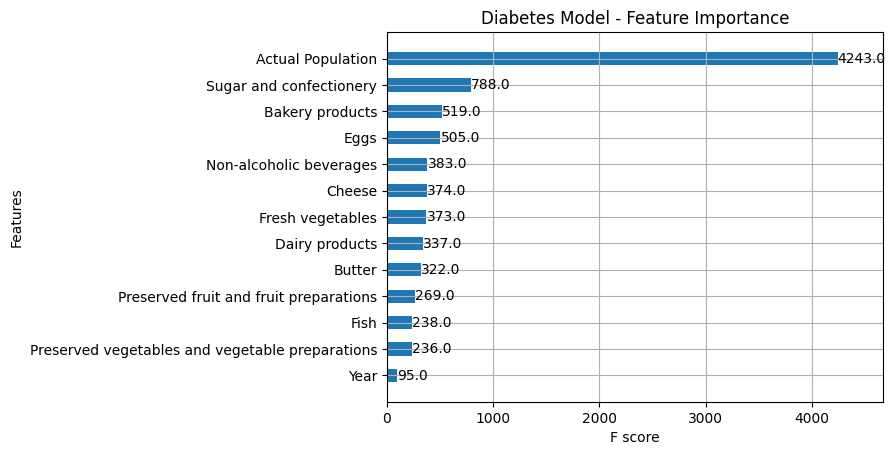

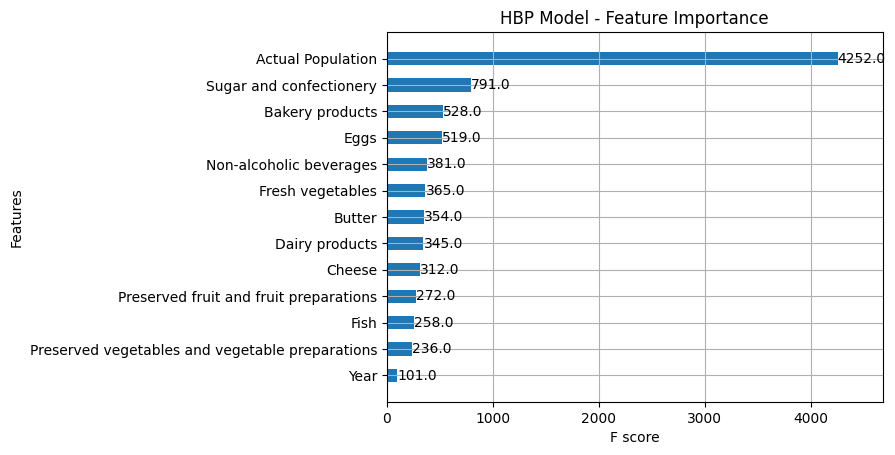

In [27]:
import matplotlib.pyplot as plt
import xgboost as xgb

# Plot feature importance for diabetes
xgb.plot_importance(best_xgb_d, title="Diabetes Model - Feature Importance", importance_type="weight", height=0.5)
plt.show()

# Plot feature importance for HBP
xgb.plot_importance(best_xgb_hbp, title="HBP Model - Feature Importance", importance_type="weight", height=0.5)
plt.show()


In [ ]:
from flask import Flask, render_template, request
import pandas as pd
import numpy as np
import joblib
from sklearn.preprocessing import StandardScaler, LabelEncoder
from xgboost import XGBRegressor
#from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score  # No longer needed here

app = Flask(__name__)

# ---- Model Training and Setup (from your notebook) ----
# This section replicates the model training steps from your notebook.  It is critical that this matches exactly.
# Load and Preprocess Data
data = pd.read_excel(r"C:\Users\ASUS\Downloads\V5_Capstone_Final_Dataset.xlsx")
data['Year'] = data['REF_DATE']  # Directly use the values as years
data = data.sort_values('Year')
latest_year = data['Year'].max()

# Encode categorical variables
label_encoders = {}
categorical_features = ['GEO', 'Age group', 'Sex']
for col in categorical_features:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])
    label_encoders[col] = le

# Define target variables
data['Diabetes_per_capita'] = data['Diabetes'] / data['Actual Population'] * 1000
data['HBP_per_capita'] = data['High Blood Pressure'] / data['Actual Population'] * 1000

# Create a dummy month feature (since we only have yearly data)
data['Month'] = 6  # Mid-year as representative

# Feature Selection Based on Correlation
selected_features = [
    'Sugar and confectionery', 'Eggs', 'Bakery products', 'Butter', 'Dairy products',
    'Cheese', 'Fresh vegetables', 'Preserved fruit and fruit preparations', 'Fish',
    'Non-alcoholic beverages', 'Preserved vegetables and vegetable preparations', 'Actual Population',
    'Year', 'Month'  # Include time-based features
]

X = data[selected_features]
y_diabetes = data['Diabetes_per_capita']
y_hbp = data['HBP_per_capita']

# Standardize the data
scaler_d = StandardScaler()
scaler_hbp = StandardScaler()

X_scaled_d_full = scaler_d.fit_transform(X)
X_scaled_hbp_full = scaler_hbp.fit_transform(X)

# XGBoost for Diabetes (based on performance)
xgb_model_d_full = XGBRegressor(n_estimators=100, learning_rate=0.05, max_depth=6, random_state=42)
xgb_model_d_full.fit(X_scaled_d_full, y_diabetes)

# XGBoost for HBP (based on performance)
xgb_model_hbp_full = XGBRegressor(n_estimators=100, learning_rate=0.05, max_depth=6, random_state=42)
xgb_model_hbp_full.fit(X_scaled_hbp_full, y_hbp)

# Save the artifacts
joblib.dump(scaler_d, "scaler_d.joblib")
joblib.dump(scaler_hbp, "scaler_hbp.joblib")
joblib.dump(xgb_model_d_full, "xgb_model_d_full.joblib")
joblib.dump(xgb_model_hbp_full, "xgb_model_hbp_full.joblib")
joblib.dump(label_encoders, "label_encoders.joblib")
joblib.dump(selected_features, "selected_features.joblib")

# Calculate feature trends for forecasting
def calculate_feature_trends(data, selected_features):
    latest_feature_values = {}
    feature_trends = data.groupby('Year')[selected_features].mean()

    for feature in selected_features:
        if feature != 'Year' and feature != 'Month':
            # Calculate average annual growth rate
            feature_data = feature_trends[feature]
            if len(feature_data) > 2:
                annual_growth = (feature_data.iloc[-1] / feature_data.iloc[0]) ** (1 / (len(feature_data) - 1)) - 1
                latest_feature_values[feature] = {'value': feature_data.iloc[-1],
                                                    'growth': annual_growth}
            else:
                # Default to last value and small growth if not enough data
                latest_feature_values[feature] = {'value': feature_data.iloc[-1], 'growth': 0.02}

    return latest_feature_values

# Generate future data for forecasting (2023-2028)
def generate_future_data(latest_year, latest_feature_values, selected_features, start_year=2023, end_year=2028):
    future_data = []

    # For each future year - starting from start_year up to end_year
    for year in range(start_year, end_year + 1):
        # Calculate years since latest year in dataset
        years_forward = year - latest_year

        # For simplicity, we'll create one record per year
        future_record = {}
        future_record['Year'] = year
        future_record['Month'] = 6  # Mid-year as representative

        # Project each feature value based on its growth trend
        for feature, info in latest_feature_values.items():
            future_record[feature] = info['value'] * (1 + info['growth']) ** years_forward

        future_data.append(future_record)

    # Create dataframe with all necessary columns
    future_df = pd.DataFrame(future_data)

    # Ensure all selected features are present
    for feature in selected_features:
        if feature not in future_df.columns:
            print(f"Warning: Adding missing feature '{feature}' with projected values")
            future_df[feature] = data[feature].mean()  # Using the mean from the historical data

    return future_df

# Load the encoders and standard scaler and Model
label_encoders = joblib.load('label_encoders.joblib')
scaler_d = joblib.load('scaler_d.joblib')
scaler_hbp = joblib.load('scaler_hbp.joblib')
xgb_model_d_full = joblib.load('xgb_model_d_full.joblib')
xgb_model_hbp_full = joblib.load('xgb_model_hbp_full.joblib')
selected_features = joblib.load('selected_features.joblib')

@app.route('/', methods=['GET', 'POST'])
def index():
    provinces = list(label_encoders['GEO'].classes_)
    return render_template('index.html', provinces=provinces)

@app.route('/predict', methods=['POST'])
def predict():
    try:
        # Get input values from the form
        province = request.form['province']
        year = int(request.form['year'])

        #Calculate feature trends from historical data
        latest_feature_values = calculate_feature_trends(data,
                                                        [f for f in selected_features if
                                                         f != 'Year' and f != 'Month'])

        # Generate future data for the selected year
        future_data = generate_future_data(latest_year, latest_feature_values, selected_features, start_year=year, end_year=year)

        # Encode the province
        future_data['GEO'] = label_encoders['GEO'].transform([province])[0]

        # Scale the future data
        future_data_scaled_d = scaler_d.transform(future_data[selected_features])
        future_data_scaled_hbp = scaler_hbp.transform(future_data[selected_features])

        # Make predictions
        diabetes_prediction = xgb_model_d_full.predict(future_data_scaled_d)[0]
        hbp_prediction = xgb_model_hbp_full.predict(future_data_scaled_hbp)[0]

        # Feature importances (already available as model attribute)
        diabetes_importances = xgb_model_d_full.feature_importances_
        hbp_importances = xgb_model_hbp_full.feature_importances_

        # Create feature importance lists
        diabetes_feature_importances = list(zip(selected_features, diabetes_importances))
        hbp_feature_importances = list(zip(selected_features, hbp_importances))

        # Render the results template
        return render_template(
            'results.html',
            province=province,
            year=year,
            diabetes_prediction=diabetes_prediction,
            hbp_prediction=hbp_prediction,
            diabetes_feature_importances=diabetes_feature_importances,
            hbp_feature_importances=hbp_feature_importances
        )

    except Exception as e:
        return render_template('error.html', error=str(e))

if __name__ == '__main__':
    app.run(debug=True)
    


In [ ]:
# import pandas as pd
# import plotly.graph_objects as go
# import plotly.offline as pyo
# from flask import Flask, render_template, request
# import numpy as np
# from sklearn.preprocessing import StandardScaler
# from xgboost import XGBRegressor
# import re

# app = Flask(__name__)

# # Load and Execute the capstone_models.ipynb (Partial Execution)
# def load_and_execute_notebook(notebook_path): # Corrected function definition
#     try:
#         with open(notebook_path, 'r', encoding='utf-8') as f:
#             notebook_content = f.read()

#         # Extract relevant code blocks (This is a simplified approach)
#         exec_globals = {}
#         # Remove IPython specific commands.
#         notebook_content = re.sub(r'^get_ipython\(\).*\n', '', notebook_content, flags=re.MULTILINE)
#         exec(notebook_content, exec_globals)

#         # Extract necessary variables
#         data = exec_globals.get('data')
#         best_xgb_d = exec_globals.get('best_xgb_d')
#         best_xgb_hbp = exec_globals.get('best_xgb_hbp')
#         selected_features = exec_globals.get('selected_features')
#         latest_year = exec_globals.get('latest_year')
#         X_train_d = exec_globals.get('X_train_d')
#         X_train_hbp = exec_globals.get('X_train_hbp')

#         # Create scalers (if they don't exist in exec_globals, create new ones)
#         if 'scaler_d_v2' in exec_globals:
#             scaler_d_v2 = exec_globals['scaler_d_v2']
#         else:
#             if X_train_d is not None and selected_features is not None:
#                 scaler_d_v2 = StandardScaler()
#                 scaler_d_v2.fit(X_train_d[selected_features])
#             else:
#                 return None, None, None, None, None, None, None
#         if 'scaler_hbp_v2' in exec_globals:
#             scaler_hbp_v2 = exec_globals['scaler_hbp_v2']
#         else:
#             if X_train_hbp is not None and selected_features is not None:
#                 scaler_hbp_v2 = StandardScaler()
#                 scaler_hbp_v2.fit(X_train_hbp[selected_features])
#             else:
#                 return None, None, None, None, None, None, None

#         return data, best_xgb_d, best_xgb_hbp, scaler_d_v2, scaler_hbp_v2, selected_features, latest_year

#     except Exception as e:
#         print(f"Error loading notebook: {e}")
#         return None, None, None, None, None, None, None

# data, diabetes_model, hbp_model, diabetes_scaler, hbp_scaler, selected_features, latest_year = load_and_execute_notebook(r"C:\Users\ASUS\Downloads\capstone_models.ipynb")

# if data is None:
#     print("Notebook loading failed. Exiting.")
#     exit(1) #Exit if loading failed.

# def generate_future_data(latest_year, latest_feature_values, selected_features, start_year=2023, end_year=2028):
#     future_data = []

#     for year in range(start_year, end_year + 1):
#         years_forward = year - latest_year
#         future_record = {}
#         future_record['Year'] = year
#         future_record['Month'] = 6
#         for feature, info in latest_feature_values.items():
#             future_record[feature] = info['value'] * (1 + info['growth']) ** years_forward
#         future_data.append(future_record)

#     future_df = pd.DataFrame(future_data)
#     for feature in selected_features:
#         if feature not in future_df.columns and feature not in ['Year', 'Month']:
#             print(f"Warning: Adding missing feature '{feature}' with projected values")
#             base_value = data[feature].mean()
#             future_df[feature] = [base_value * (1.02 ** (i+1)) for i in range(len(future_df))]

#     return future_df

# def calculate_feature_trends(data, selected_features):
#     latest_feature_values = {}
#     feature_trends = data.groupby('Year')[selected_features].mean()

#     for feature in selected_features:
#         if feature != 'Year' and feature != 'Month':
#             feature_data = feature_trends[feature]
#             if len(feature_data) > 2:
#                 annual_growth = (feature_data.iloc[-1] / feature_data.iloc[0]) ** (1/(len(feature_data)-1)) - 1
#                 latest_feature_values[feature] = {'value': feature_data.iloc[-1], 'growth': annual_growth}
#             else:
#                 latest_feature_values[feature] = {'value': feature_data.iloc[-1], 'growth': 0.02}

#     return latest_feature_values

# def forecast_data(input_data):
#     future_data_scaled_d_v2 = diabetes_scaler.transform(input_data[selected_features])
#     future_data_scaled_hbp_v2 = hbp_scaler.transform(input_data[selected_features])

#     diabetes_predictions = diabetes_model.predict(future_data_scaled_d_v2)
#     hbp_predictions = hbp_model.predict(future_data_scaled_hbp_v2)

#     diabetes_forecast = pd.DataFrame({'Year': input_data['Year'], 'Forecast': diabetes_predictions})
#     hbp_forecast = pd.DataFrame({'Year': input_data['Year'], 'Forecast': hbp_predictions})

#     return diabetes_forecast, hbp_forecast

# @app.route('/', methods=['GET', 'POST'])
# def index():
#     if request.method == 'POST':
#         future_data_v2 = generate_future_data(latest_year, calculate_feature_trends(data, selected_features), selected_features)
#         diabetes_forecast, hbp_forecast = forecast_data(future_data_v2)

#         historical_diabetes = data.groupby('Year')['Diabetes_per_capita'].mean()
#         historical_hbp = data.groupby('Year')['HBP_per_capita'].mean()

#         fig_d = go.Figure()
#         fig_d.add_trace(go.Scatter(x=historical_diabetes.index, y=historical_diabetes.values, mode='lines+markers', name='Historical Diabetes', line=dict(color='blue')))
#         fig_d.add_trace(go.Scatter(x=diabetes_forecast['Year'], y=diabetes_forecast['Forecast'], mode='lines+markers', name='Forecast Diabetes', line=dict(color='red')))
#         fig_d.update_layout(title="📊 Diabetes per 1000 People - Historical & Forecast", xaxis_title="Year", yaxis_title="Cases per 1000 People", template="plotly_dark")
#         plot_d = pyo.plot(fig_d, output_type='div')

#         fig_hbp = go.Figure()
#         fig_hbp.add_trace(go.Scatter(x=historical_hbp.index, y=historical_hbp.values, mode='lines+markers', name='Historical HBP', line=dict(color='green')))
#         fig_hbp.add_trace(go.Scatter(x=hbp_forecast['Year'], y=hbp_forecast['Forecast'], mode='lines+markers', name='Forecast HBP', line=dict(color='orange')))
#         fig_hbp.update_layout(title="📊 High Blood Pressure per 1000 People - Historical & Forecast", xaxis_title="Year", yaxis_title="Cases per 1000 People", template="plotly_dark")
#         plot_hbp = pyo.plot(fig_hbp, output_type='div')

#         return render_template('index.html', plot_d=plot_d, plot_hbp=plot_hbp, diabetes_forecast=diabetes_forecast.to_html(), hbp_forecast=hbp_forecast.to_html())

#     return render_template('index.html')

# if __name__ == '__main__':
#     app.run(debug=True)

Error loading notebook: name 'true' is not defined
Notebook loading failed. Exiting.
 * Serving Flask app '__main__'
 * Debug mode: on


 * Running on http://127.0.0.1:5000
Press CTRL+C to quit
 * Restarting with stat


In [ ]:
# import pandas as pd
# import numpy as np
# from statsmodels.tsa.stattools import adfuller, acf
# from scipy import stats

# # =====================
# # DATA PREPARATION
# # =====================
# def prepare_time_series(df, target_col):
#     """Convert raw data to rate per 1000 population with food features"""
#     ts_data = df.groupby('REF_DATE').agg({
#         target_col: 'sum',
#         'Actual Population': 'sum'
#     })
#     ts_data[f'{target_col}_Rate'] = (ts_data[target_col] / ts_data['Actual Population']) * 1000
#     ts_data.index = pd.to_datetime(ts_data.index, format='%Y')
#     return ts_data[[f'{target_col}_Rate']]

# # Prepare both datasets
# diabetes_data = prepare_time_series(data, 'Diabetes')
# hbp_data = prepare_time_series(data, 'High Blood Pressure')

# # =====================
# # TRENDS
# # =====================
# def calculate_trend(df, target_col):
#     """Calculate overall trend using linear regression"""
#     x = np.arange(len(df))
#     y = df[target_col].values
#     slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
    
#     print(f"\n=== Trend Analysis for {target_col} ===")
#     print(f"Slope: {slope}")
#     print(f"R-squared: {r_value ** 2}")
#     print("Increasing" if slope > 0 else "Decreasing" if slope < 0 else "No significant trend")

# # Diabetes trend
# calculate_trend(diabetes_data, 'Diabetes_Rate')
# # High Blood Pressure trend
# calculate_trend(hbp_data, 'High Blood Pressure_Rate')

# # =====================
# # OUTLIERS
# # =====================
# def detect_outliers(df, target_col):
#     """Detect outliers using IQR method"""
#     q1 = df[target_col].quantile(0.25)
#     q3 = df[target_col].quantile(0.75)
#     iqr = q3 - q1
#     lower_bound = q1 - 1.5 * iqr
#     upper_bound = q3 + 1.5 * iqr
    
#     outliers = df[(df[target_col] < lower_bound) | (df[target_col] > upper_bound)]
    
#     print(f"\n=== Outliers for {target_col} ===")
#     if not outliers.empty:
#         print(outliers)
#     else:
#         print("No significant outliers detected")

# # Diabetes outliers
# detect_outliers(diabetes_data, 'Diabetes_Rate')
# # High Blood Pressure outliers
# detect_outliers(hbp_data, 'High Blood Pressure_Rate')

# # =====================
# # SEASONALITY
# # =====================
# def check_seasonality(df, target_col):
#     """Check seasonality using autocorrelation"""
#     autocorr = acf(df[target_col], nlags=12)
#     significant_lags = [i for i, value in enumerate(autocorr) if abs(value) > 0.5]
    
#     print(f"\n=== Seasonality Check for {target_col} ===")
#     if significant_lags:
#         print(f"Seasonal patterns detected at lags: {significant_lags}")
#     else:
#         print("No strong seasonal patterns detected")

# # Diabetes seasonality
# check_seasonality(diabetes_data, 'Diabetes_Rate')
# # High Blood Pressure seasonality
# check_seasonality(hbp_data, 'High Blood Pressure_Rate')

# # =====================
# # STATIONARITY
# # =====================
# def check_stationarity(df, target_col):
#     """Check stationarity using Augmented Dickey-Fuller Test"""
#     adf_test = adfuller(df[target_col])
    
#     print(f"\n=== Stationarity Test for {target_col} ===")
#     print(f"ADF Statistic: {adf_test[0]}")
#     print(f"p-value: {adf_test[1]}")
#     print("Stationary" if adf_test[1] < 0.05 else "Non-stationary")

# # Diabetes stationarity
# check_stationarity(diabetes_data, 'Diabetes_Rate')
# # High Blood Pressure stationarity
# check_stationarity(hbp_data, 'High Blood Pressure_Rate')


In [ ]:
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt
# import seaborn as sns
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import StandardScaler
# from statsmodels.tsa.arima.model import ARIMA
# from statsmodels.tsa.statespace.sarimax import SARIMAX
# from prophet import Prophet
# from xgboost import XGBRegressor
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import LSTM, Dense
# from sklearn.metrics import mean_squared_error, mean_absolute_error
# import warnings

# warnings.filterwarnings('ignore')
# sns.set_style("whitegrid")
# sns.set_palette("husl")

# # Load the data
# print("Loading data...")
# data = pd.read_excel(r"C:\Users\ASUS\Downloads\V5_Capstone_Final_Dataset.xlsx")  # Replace with your actual data file
# print("Data loaded. Shape:", data.shape)

# # Prepare the data
# data['REF_DATE'] = pd.to_datetime(data['REF_DATE'])
# data = data.sort_values('REF_DATE')

# # Select features for modeling
# features = ['Total, food services and drinking places -revenue in thousands', 'Actual Population',
#             'Coffee&Tea', 'Fish', 'Bakery products', 'Butter', 'Cereal products (excluding baby food)',
#             'Cheese', 'Dairy products', 'Edible fats and oils', 'Eggs', 'Fish, seafood and other marine products',
#             'Fresh fruit', 'Fresh milk', 'Fresh vegetables', 'Fruit, fruit preparations and nuts',
#             'Meat', 'Non-alcoholic beverages', 'Preserved fruit and fruit preparations',
#             'Preserved vegetables and vegetable preparations', 'Processed meat', 'Sugar and confectionery',
#             'Vegetables and vegetable preparations']

# X = data[features]
# y_diabetes = data['Diabetes']
# y_hbp = data['High Blood Pressure']

# print("Features shape:", X.shape)
# print("Diabetes target shape:", y_diabetes.shape)
# print("High Blood Pressure target shape:", y_hbp.shape)

# # Split the data
# X_train, X_test, y_diabetes_train, y_diabetes_test, y_hbp_train, y_hbp_test, dates_train, dates_test = train_test_split(
#     X, y_diabetes, y_hbp, data['REF_DATE'], test_size=0.2, random_state=42)

# print("Training set size:", len(X_train))
# print("Test set size:", len(X_test))

# # Standardize the features
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)

# # Modified evaluation function to store predictions
# def evaluate_model(y_true, y_pred, model_name, results_dict):
#     mse = mean_squared_error(y_true, y_pred)
#     mae = mean_absolute_error(y_true, y_pred)
#     print(f"{model_name} - MSE: {mse:.4f}, MAE: {mae:.4f}")
#     results_dict[model_name] = {
#         'MSE': mse,
#         'MAE': mae,
#         'Predictions': y_pred.copy()
#     }
#     return y_pred

# # Model fitting functions remain the same
# def fit_arima(y_train, y_test, results_dict):
#     print("Fitting ARIMA model...")
#     model = ARIMA(y_train, order=(1,1,1))
#     results = model.fit()
#     forecast = results.forecast(steps=len(y_test))
#     return evaluate_model(y_test, forecast, "ARIMA", results_dict)

# def fit_sarima(y_train, y_test, results_dict):
#     print("Fitting SARIMA model...")
#     model = SARIMAX(y_train, order=(1,1,1), seasonal_order=(1,1,1,12))
#     results = model.fit()
#     forecast = results.forecast(steps=len(y_test))
#     return evaluate_model(y_test, forecast, "SARIMA", results_dict)

# def fit_prophet(y_train, y_test, dates_train, dates_test, results_dict):
#     print("Fitting Prophet model...")
#     df = pd.DataFrame({'ds': dates_train, 'y': y_train})
#     model = Prophet()
#     model.fit(df)
#     future = pd.DataFrame({'ds': dates_test})
#     forecast = model.predict(future)
#     return evaluate_model(y_test, forecast['yhat'], "Prophet", results_dict)

# def fit_xgboost(X_train, X_test, y_train, y_test, results_dict):
#     print("Fitting XGBoost model...")
#     model = XGBRegressor(random_state=42)
#     model.fit(X_train, y_train)
#     predictions = model.predict(X_test)
#     return evaluate_model(y_test, predictions, "XGBoost", results_dict)

# def fit_lstm(X_train, X_test, y_train, y_test, results_dict):
#     print("Fitting LSTM model...")
#     X_train_reshaped = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
#     X_test_reshaped = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))
    
#     model = Sequential([
#         LSTM(50, activation='relu', input_shape=(1, X_train.shape[1])),
#         Dense(1)
#     ])
#     model.compile(optimizer='adam', loss='mse')
#     model.fit(X_train_reshaped, y_train, epochs=50, batch_size=32, verbose=0)
#     predictions = model.predict(X_test_reshaped).flatten()
#     return evaluate_model(y_test, predictions, "LSTM", results_dict)

# # New visualization functions
# def plot_time_series_comparison(dates_test, y_true, predictions_dict, title):
#     df = pd.DataFrame({
#         'Date': dates_test,
#         'Actual': y_true
#     })
#     for model_name, pred in predictions_dict.items():
#         df[model_name] = pred
    
#     df = df.sort_values('Date').reset_index(drop=True)
    
#     plt.figure(figsize=(15, 10))
#     plt.suptitle(title, fontsize=16, y=1.02)
    
#     models = list(predictions_dict.keys())
#     for i, model in enumerate(models, 1):
#         plt.subplot(3, 2, i)
#         sns.lineplot(data=df, x='Date', y='Actual', label='Actual')
#         sns.lineplot(data=df, x='Date', y=model, label=model)
#         plt.title(f'{model} vs Actual')
#         plt.xlabel('Date')
#         plt.ylabel('Value')
#         plt.xticks(rotation=45)
#         plt.grid(True)
#         plt.legend()
#     plt.tight_layout()
#     plt.show()

# def plot_metrics_comparison(results_dict, title):
#     metrics = ['MSE', 'MAE']
#     model_names = list(results_dict.keys())
    
#     plt.figure(figsize=(12, 6))
#     x = np.arange(len(model_names))
#     width = 0.4
    
#     # MSE values
#     mse_values = [results_dict[name]['MSE'] for name in model_names]
#     # MAE values
#     mae_values = [results_dict[name]['MAE'] for name in model_names]
    
#     plt.bar(x - width/2, mse_values, width, label='MSE')
#     plt.bar(x + width/2, mae_values, width, label='MAE')
    
#     plt.title(title, fontsize=14)
#     plt.ylabel('Error Value', fontsize=12)
#     plt.xticks(x, model_names, rotation=45)
#     plt.legend()
#     plt.grid(True)
#     plt.show()

# def plot_predicted_vs_actual(y_true, y_pred, model_name):
#     plt.figure(figsize=(8, 6))
#     sns.scatterplot(x=y_true, y=y_pred, alpha=0.6)
#     plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'k--', lw=2)
#     plt.title(f'{model_name} Prediction Accuracy', fontsize=14)
#     plt.xlabel('Actual Values', fontsize=12)
#     plt.ylabel('Predicted Values', fontsize=12)
#     plt.grid(True)
#     plt.show()

# def determine_best_model(results_dict):
#     return min(results_dict, key=lambda k: results_dict[k]['MSE'])

# # Run comparisons for Diabetes
# print("\nDiabetes Forecasting:")
# diabetes_results = {}
# arima_diabetes_pred = fit_arima(y_diabetes_train, y_diabetes_test, diabetes_results)
# sarima_diabetes_pred = fit_sarima(y_diabetes_train, y_diabetes_test, diabetes_results)
# prophet_diabetes_pred = fit_prophet(y_diabetes_train, y_diabetes_test, dates_train, dates_test, diabetes_results)
# xgboost_diabetes_pred = fit_xgboost(X_train_scaled, X_test_scaled, y_diabetes_train, y_diabetes_test, diabetes_results)
# lstm_diabetes_pred = fit_lstm(X_train_scaled, X_test_scaled, y_diabetes_train, y_diabetes_test, diabetes_results)

# # Create predictions dictionary for diabetes
# diabetes_predictions = {
#     'ARIMA': arima_diabetes_pred,
#     'SARIMA': sarima_diabetes_pred,
#     'Prophet': prophet_diabetes_pred,
#     'XGBoost': xgboost_diabetes_pred,
#     'LSTM': lstm_diabetes_pred
# }

# # Visualizations for Diabetes
# plot_time_series_comparison(dates_test, y_diabetes_test, diabetes_predictions, "Diabetes Forecasting Models Comparison")
# plot_metrics_comparison(diabetes_results, "Diabetes Model Performance Comparison")
# best_diabetes_model = determine_best_model(diabetes_results)
# plot_predicted_vs_actual(y_diabetes_test, 
#                         diabetes_results[best_diabetes_model]['Predictions'], 
#                         best_diabetes_model)

# # Run comparisons for High Blood Pressure
# print("\nHigh Blood Pressure Forecasting:")
# hbp_results = {}
# arima_hbp_pred = fit_arima(y_hbp_train, y_hbp_test, hbp_results)
# sarima_hbp_pred = fit_sarima(y_hbp_train, y_hbp_test, hbp_results)
# prophet_hbp_pred = fit_prophet(y_hbp_train, y_hbp_test, dates_train, dates_test, hbp_results)
# xgboost_hbp_pred = fit_xgboost(X_train_scaled, X_test_scaled, y_hbp_train, y_hbp_test, hbp_results)
# lstm_hbp_pred = fit_lstm(X_train_scaled, X_test_scaled, y_hbp_train, y_hbp_test, hbp_results)

# # Create predictions dictionary for HBP
# hbp_predictions = {
#     'ARIMA': arima_hbp_pred,
#     'SARIMA': sarima_hbp_pred,
#     'Prophet': prophet_hbp_pred,
#     'XGBoost': xgboost_hbp_pred,
#     'LSTM': lstm_hbp_pred
# }

# # Visualizations for High Blood Pressure
# plot_time_series_comparison(dates_test, y_hbp_test, hbp_predictions, "High Blood Pressure Forecasting Models Comparison")
# plot_metrics_comparison(hbp_results, "High Blood Pressure Model Performance Comparison")
# best_hbp_model = determine_best_model(hbp_results)
# plot_predicted_vs_actual(y_hbp_test, 
#                         hbp_results[best_hbp_model]['Predictions'], 
#                         best_hbp_model)

# print("\nBest Models Summary:")
# print(f"Diabetes: {best_diabetes_model}")
# print(f"High Blood Pressure: {best_hbp_model}")

In [5]:
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt
# import seaborn as sns
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import StandardScaler, LabelEncoder
# from statsmodels.tsa.arima.model import ARIMA
# from statsmodels.tsa.statespace.sarimax import SARIMAX
# from prophet import Prophet
# from xgboost import XGBRegressor
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import LSTM, Dense
# from sklearn.metrics import mean_squared_error, mean_absolute_error
# import warnings

# warnings.filterwarnings('ignore')
# sns.set_style("whitegrid")
# sns.set_palette("husl")

# # Load the data
# data = pd.read_excel(r"C:\Users\ASUS\Downloads\V5_Capstone_Final_Dataset.xlsx")  # Replace with actual file path

# # Convert REF_DATE to datetime
# data['REF_DATE'] = pd.to_datetime(data['REF_DATE'])
# data = data.sort_values('REF_DATE')

# # Encode categorical variables
# label_encoders = {}
# categorical_features = ['GEO', 'Age group', 'Sex']

# for col in categorical_features:
#     le = LabelEncoder()
#     data[col] = le.fit_transform(data[col])
#     label_encoders[col] = le  # Store encoders for future reference

# # Select features for modeling
# features = ['Total, food services and drinking places -revenue in thousands', 'Actual Population',
#             'Coffee&Tea', 'Fish', 'Bakery products', 'Butter', 'Cereal products (excluding baby food)',
#             'Cheese', 'Dairy products', 'Edible fats and oils', 'Eggs', 'Fish, seafood and other marine products',
#             'Fresh fruit', 'Fresh milk', 'Fresh vegetables', 'Fruit, fruit preparations and nuts',
#             'Meat', 'Non-alcoholic beverages', 'Preserved fruit and fruit preparations',
#             'Preserved vegetables and vegetable preparations', 'Processed meat', 'Sugar and confectionery',
#             'Vegetables and vegetable preparations', 'GEO', 'Age group', 'Sex']  # Include encoded categorical features

# X = data[features]
# y_diabetes = data['Diabetes']
# y_hbp = data['High Blood Pressure']

# # Split the data
# X_train, X_test, y_diabetes_train, y_diabetes_test, y_hbp_train, y_hbp_test, dates_train, dates_test = train_test_split(
#     X, y_diabetes, y_hbp, data['REF_DATE'], test_size=0.2, random_state=42)

# # Standardize the features
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)

# # Model evaluation function
# def evaluate_model(y_true, y_pred, model_name, results_dict):
#     mse = mean_squared_error(y_true, y_pred)
#     rmse = np.sqrt(mse)
#     mae = mean_absolute_error(y_true, y_pred)
#     results_dict[model_name] = {
#         'MSE': mse,
#         'RMSE': rmse,
#         'MAE': mae,
#         'Predictions': y_pred.copy(),
#         'Actual': y_true.copy()
#     }
#     return y_pred

# # Define model training functions
# def fit_arima(y_train, y_test, results_dict):
#     model = ARIMA(y_train, order=(1,1,1)).fit()
#     forecast = model.forecast(steps=len(y_test))
#     return evaluate_model(y_test, forecast, "ARIMA", results_dict)

# def fit_sarima(y_train, y_test, results_dict):
#     model = SARIMAX(y_train, order=(1,1,1), seasonal_order=(1,1,1,12)).fit()
#     forecast = model.forecast(steps=len(y_test))
#     return evaluate_model(y_test, forecast, "SARIMA", results_dict)

# def fit_prophet(y_train, y_test, dates_train, dates_test, results_dict):
#     df = pd.DataFrame({'ds': dates_train, 'y': y_train})
#     model = Prophet()
#     model.fit(df)
#     forecast = model.predict(pd.DataFrame({'ds': dates_test}))
#     return evaluate_model(y_test, forecast['yhat'], "Prophet", results_dict)

# def fit_xgboost(X_train, X_test, y_train, y_test, results_dict):
#     model = XGBRegressor(random_state=42)
#     model.fit(X_train, y_train)
#     predictions = model.predict(X_test)
#     return evaluate_model(y_test, predictions, "XGBoost", results_dict)

# def fit_lstm(X_train, X_test, y_train, y_test, results_dict):
#     X_train_reshaped = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
#     X_test_reshaped = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))
    
#     model = Sequential([
#         LSTM(50, activation='relu', input_shape=(1, X_train.shape[1])),
#         Dense(1)
#     ])
#     model.compile(optimizer='adam', loss='mse')
#     model.fit(X_train_reshaped, y_train, epochs=50, batch_size=32, verbose=0)
#     predictions = model.predict(X_test_reshaped).flatten()
#     return evaluate_model(y_test, predictions, "LSTM", results_dict)

# # Run forecasting for Diabetes
# diabetes_results = {}
# print("Training Diabetes models...")
# arima_diabetes_pred = fit_arima(y_diabetes_train, y_diabetes_test, diabetes_results)
# sarima_diabetes_pred = fit_sarima(y_diabetes_train, y_diabetes_test, diabetes_results)
# prophet_diabetes_pred = fit_prophet(y_diabetes_train, y_diabetes_test, dates_train, dates_test, diabetes_results)
# xgboost_diabetes_pred = fit_xgboost(X_train_scaled, X_test_scaled, y_diabetes_train, y_diabetes_test, diabetes_results)
# lstm_diabetes_pred = fit_lstm(X_train_scaled, X_test_scaled, y_diabetes_train, y_diabetes_test, diabetes_results)

# # Run forecasting for High Blood Pressure
# hbp_results = {}
# print("Training High Blood Pressure models...")
# arima_hbp_pred = fit_arima(y_hbp_train, y_hbp_test, hbp_results)
# sarima_hbp_pred = fit_sarima(y_hbp_train, y_hbp_test, hbp_results)
# prophet_hbp_pred = fit_prophet(y_hbp_train, y_hbp_test, dates_train, dates_test, hbp_results)
# xgboost_hbp_pred = fit_xgboost(X_train_scaled, X_test_scaled, y_hbp_train, y_hbp_test, hbp_results)
# lstm_hbp_pred = fit_lstm(X_train_scaled, X_test_scaled, y_hbp_train, y_hbp_test, hbp_results)

# # Determine best models
# def determine_best_model(results_dict):
#     return min(results_dict, key=lambda k: results_dict[k]['MSE'])

# best_diabetes_model = determine_best_model(diabetes_results)
# best_hbp_model = determine_best_model(hbp_results)

# print("\nBest Models Summary:")
# print(f"Diabetes: {best_diabetes_model}")
# print(f"High Blood Pressure: {best_hbp_model}")

# # Create comparison tables for metrics
# def create_metrics_table(results_dict):
#     metrics = ['MSE', 'RMSE', 'MAE']
#     metrics_data = {metric: [results_dict[model][metric] for model in results_dict] for metric in metrics}
#     return pd.DataFrame(metrics_data, index=list(results_dict.keys()))

# # Create visualization functions
# def plot_error_metrics(diabetes_results, hbp_results):
#     """
#     Plot bar charts comparing error metrics across models
#     """
#     fig, axes = plt.subplots(2, 3, figsize=(18, 12))
#     fig.suptitle('Model Performance Comparison - Error Metrics', fontsize=16)
    
#     metrics = ['MSE', 'RMSE', 'MAE']
    
#     for i, metric in enumerate(metrics):
#         # Diabetes metrics
#         diabetes_values = [diabetes_results[model][metric] for model in diabetes_results]
#         axes[0, i].bar(list(diabetes_results.keys()), diabetes_values, color=sns.color_palette("husl", len(diabetes_results)))
#         axes[0, i].set_title(f'Diabetes - {metric}')
#         axes[0, i].set_xlabel('Models')
#         axes[0, i].set_ylabel(metric)
#         axes[0, i].tick_params(axis='x', rotation=45)
        
#         # HBP metrics
#         hbp_values = [hbp_results[model][metric] for model in hbp_results]
#         axes[1, i].bar(list(hbp_results.keys()), hbp_values, color=sns.color_palette("husl", len(hbp_results)))
#         axes[1, i].set_title(f'High Blood Pressure - {metric}')
#         axes[1, i].set_xlabel('Models')
#         axes[1, i].set_ylabel(metric)
#         axes[1, i].tick_params(axis='x', rotation=45)
    
#     plt.tight_layout(rect=[0, 0, 1, 0.96])
#     plt.savefig('model_metrics_comparison.png', dpi=300, bbox_inches='tight')
#     plt.show()

# def plot_actual_vs_predicted(diabetes_results, hbp_results, dates_test):
#     """
#     Plot actual vs predicted values for the best models
#     """
#     best_diabetes_model = determine_best_model(diabetes_results)
#     best_hbp_model = determine_best_model(hbp_results)
    
#     fig, axes = plt.subplots(2, 1, figsize=(15, 12))
    
#     # Plot diabetes actual vs predicted
#     axes[0].plot(dates_test, diabetes_results[best_diabetes_model]['Actual'], 'o-', label='Actual', color='blue')
#     axes[0].plot(dates_test, diabetes_results[best_diabetes_model]['Predictions'], 'o--', label=f'Predicted ({best_diabetes_model})', color='red')
#     axes[0].set_title(f'Diabetes - Actual vs Predicted ({best_diabetes_model})', fontsize=14)
#     axes[0].set_xlabel('Date')
#     axes[0].set_ylabel('Diabetes Rate')
#     axes[0].legend()
#     axes[0].grid(True)
    
#     # Plot HBP actual vs predicted
#     axes[1].plot(dates_test, hbp_results[best_hbp_model]['Actual'], 'o-', label='Actual', color='green')
#     axes[1].plot(dates_test, hbp_results[best_hbp_model]['Predictions'], 'o--', label=f'Predicted ({best_hbp_model})', color='purple')
#     axes[1].set_title(f'High Blood Pressure - Actual vs Predicted ({best_hbp_model})', fontsize=14)
#     axes[1].set_xlabel('Date')
#     axes[1].set_ylabel('High Blood Pressure Rate')
#     axes[1].legend()
#     axes[1].grid(True)
    
#     plt.tight_layout()
#     plt.savefig('best_models_predictions.png', dpi=300, bbox_inches='tight')
#     plt.show()

# def plot_all_models_predictions(diabetes_results, hbp_results, dates_test):
#     """
#     Plot predictions from all models against actual values
#     """
#     # Diabetes predictions
#     plt.figure(figsize=(15, 8))
#     plt.plot(dates_test, diabetes_results['ARIMA']['Actual'], 'o-', label='Actual', color='black', linewidth=2)
    
#     colors = sns.color_palette("husl", len(diabetes_results))
#     for i, model in enumerate(diabetes_results.keys()):
#         plt.plot(dates_test, diabetes_results[model]['Predictions'], '--', label=f'{model} Predicted', color=colors[i])
    
#     plt.title('Diabetes - All Models Predictions Comparison', fontsize=14)
#     plt.xlabel('Date')
#     plt.ylabel('Diabetes Rate')
#     plt.legend()
#     plt.grid(True)
#     plt.tight_layout()
#     plt.savefig('diabetes_all_models.png', dpi=300, bbox_inches='tight')
#     plt.show()
    
#     # HBP predictions
#     plt.figure(figsize=(15, 8))
#     plt.plot(dates_test, hbp_results['ARIMA']['Actual'], 'o-', label='Actual', color='black', linewidth=2)
    
#     for i, model in enumerate(hbp_results.keys()):
#         plt.plot(dates_test, hbp_results[model]['Predictions'], '--', label=f'{model} Predicted', color=colors[i])
    
#     plt.title('High Blood Pressure - All Models Predictions Comparison', fontsize=14)
#     plt.xlabel('Date')
#     plt.ylabel('High Blood Pressure Rate')
#     plt.legend()
#     plt.grid(True)
#     plt.tight_layout()
#     plt.savefig('hbp_all_models.png', dpi=300, bbox_inches='tight')
#     plt.show()

# def plot_prediction_errors(diabetes_results, hbp_results):
#     """
#     Plot prediction errors (residuals) for each model
#     """
#     fig, axes = plt.subplots(2, 1, figsize=(15, 12))
    
#     # Diabetes prediction errors
#     for model in diabetes_results:
#         errors = diabetes_results[model]['Actual'] - diabetes_results[model]['Predictions']
#         axes[0].scatter(range(len(errors)), errors, label=model, alpha=0.7)
    
#     axes[0].axhline(y=0, color='black', linestyle='-', linewidth=1)
#     axes[0].set_title('Diabetes Prediction Errors (Residuals)', fontsize=14)
#     axes[0].set_xlabel('Observation Index')
#     axes[0].set_ylabel('Error (Actual - Predicted)')
#     axes[0].legend()
#     axes[0].grid(True)
    
#     # HBP prediction errors
#     for model in hbp_results:
#         errors = hbp_results[model]['Actual'] - hbp_results[model]['Predictions']
#         axes[1].scatter(range(len(errors)), errors, label=model, alpha=0.7)
    
#     axes[1].axhline(y=0, color='black', linestyle='-', linewidth=1)
#     axes[1].set_title('High Blood Pressure Prediction Errors (Residuals)', fontsize=14)
#     axes[1].set_xlabel('Observation Index')
#     axes[1].set_ylabel('Error (Actual - Predicted)')
#     axes[1].legend()
#     axes[1].grid(True)
    
#     plt.tight_layout()
#     plt.savefig('prediction_errors.png', dpi=300, bbox_inches='tight')
#     plt.show()

# # Print metrics tables
# print("\n=== Diabetes Model Metrics ===")
# diabetes_metrics = create_metrics_table(diabetes_results)
# print(diabetes_metrics)

# print("\n=== High Blood Pressure Model Metrics ===")
# hbp_metrics = create_metrics_table(hbp_results)
# print(hbp_metrics)


Training Diabetes models...


14:08:35 - cmdstanpy - INFO - Chain [1] start processing
14:08:35 - cmdstanpy - INFO - Chain [1] done processing


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step  
Training High Blood Pressure models...


14:08:46 - cmdstanpy - INFO - Chain [1] start processing
14:08:46 - cmdstanpy - INFO - Chain [1] done processing


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step 

Best Models Summary:
Diabetes: XGBoost
High Blood Pressure: XGBoost

=== Diabetes Model Metrics ===
                  MSE          RMSE           MAE
ARIMA    1.554407e+09  39425.962355  25709.638096
SARIMA   1.596922e+09  39961.507765  23549.134883
Prophet  1.538709e+09  39226.382856  25070.195413
XGBoost  7.298591e+07   8543.179334   4050.625407
LSTM     1.805935e+09  42496.289644  17382.800970

=== High Blood Pressure Model Metrics ===
                  MSE           RMSE           MAE
ARIMA    1.008058e+10  100402.109208  60862.604121
SARIMA   1.043516e+10  102152.617945  59334.635397
Prophet  1.001996e+10  100099.731023  59391.272318
XGBoost  2.416060e+08   15543.679938   6746.965338
LSTM     1.242813e+10  111481.536707  49510.101139


### Model comparison after encoding


Diabetes Forecasting:


16:20:33 - cmdstanpy - INFO - Chain [1] start processing
16:20:33 - cmdstanpy - INFO - Chain [1] done processing


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step 


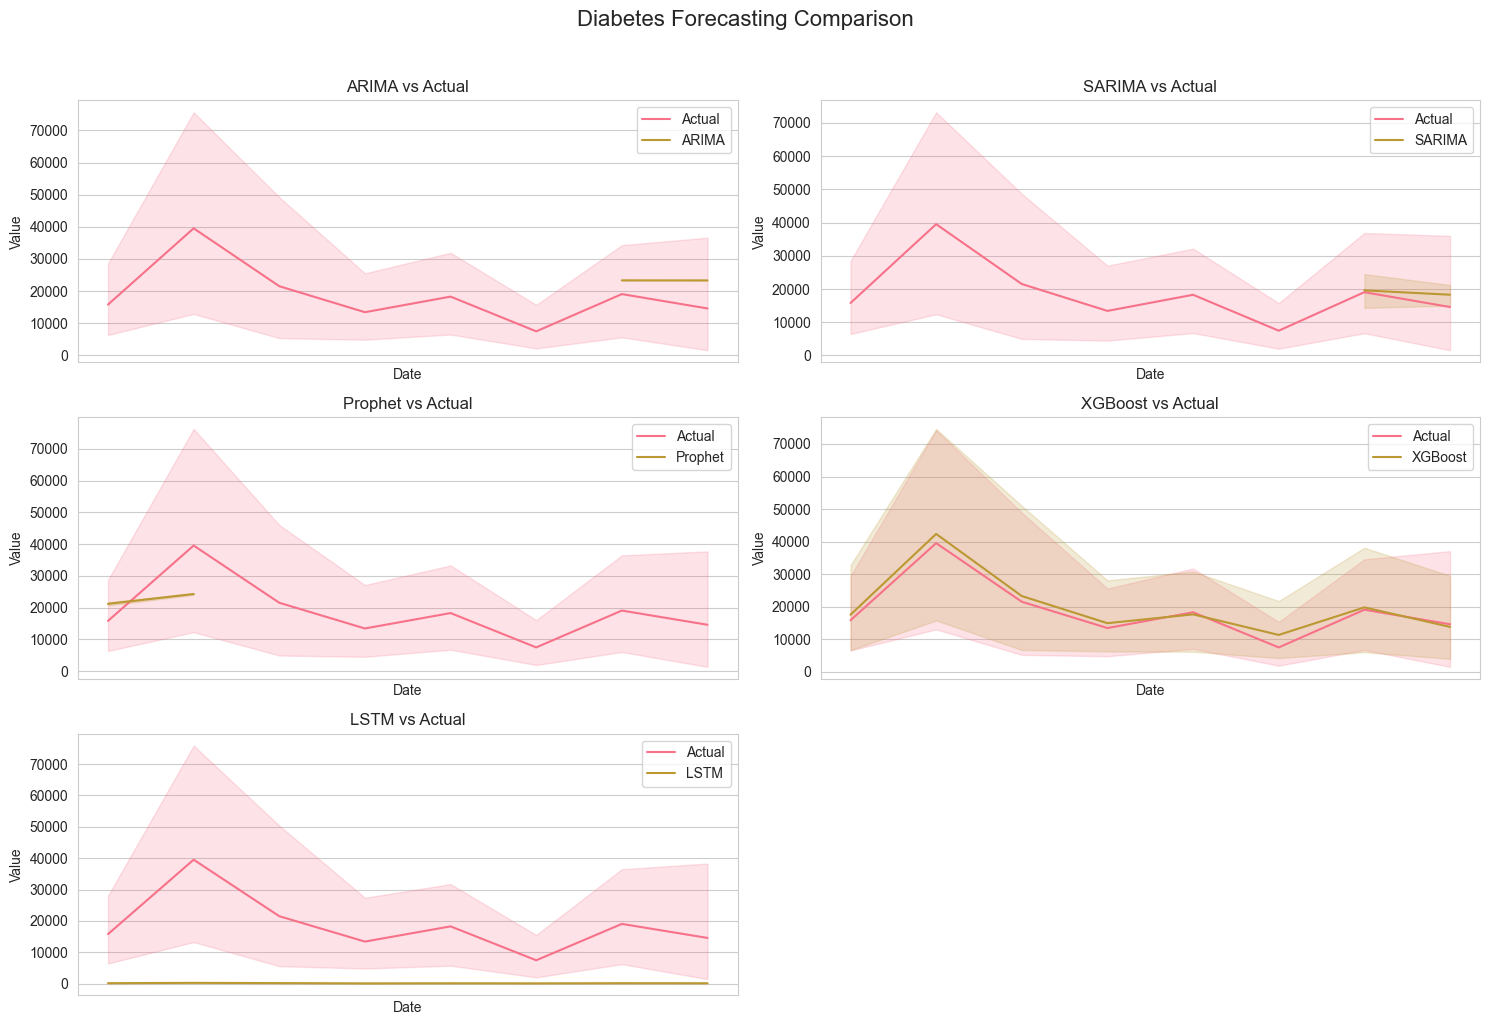

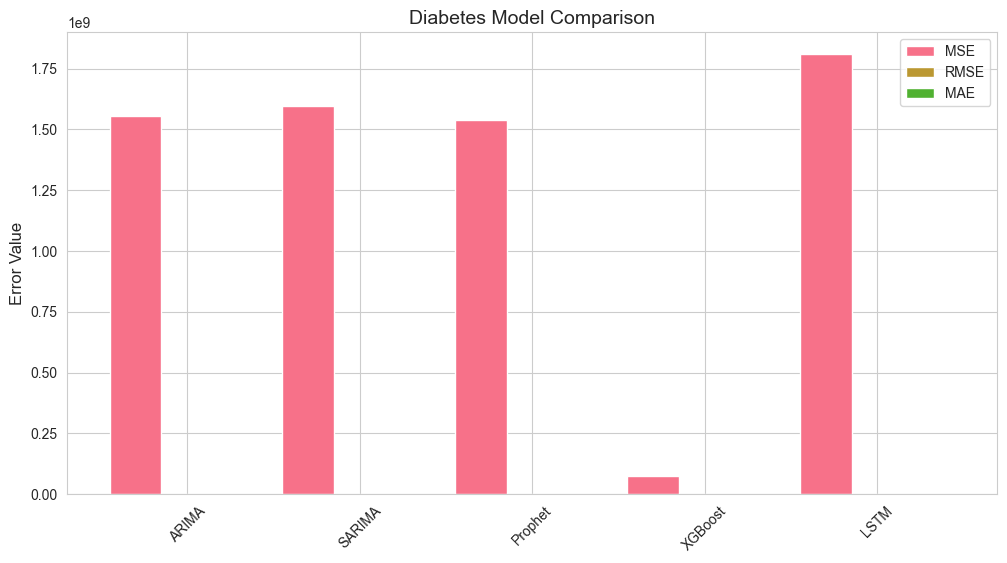


Best Models Summary:
Diabetes: XGBoost

=== Diabetes Model Metrics ===
                       MSE          RMSE           MAE
ARIMA    1554406507.625254  39425.962355  25709.638096
SARIMA   1596922102.867229  39961.507765  23549.134883
Prophet  1538709111.932135  39226.382856  25070.195413
XGBoost    72985913.128896   8543.179334   4050.625407
LSTM     1809725803.550287  42540.872153  17384.480538

High Blood Pressure Forecasting:


16:20:51 - cmdstanpy - INFO - Chain [1] start processing
16:20:51 - cmdstanpy - INFO - Chain [1] done processing


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step 


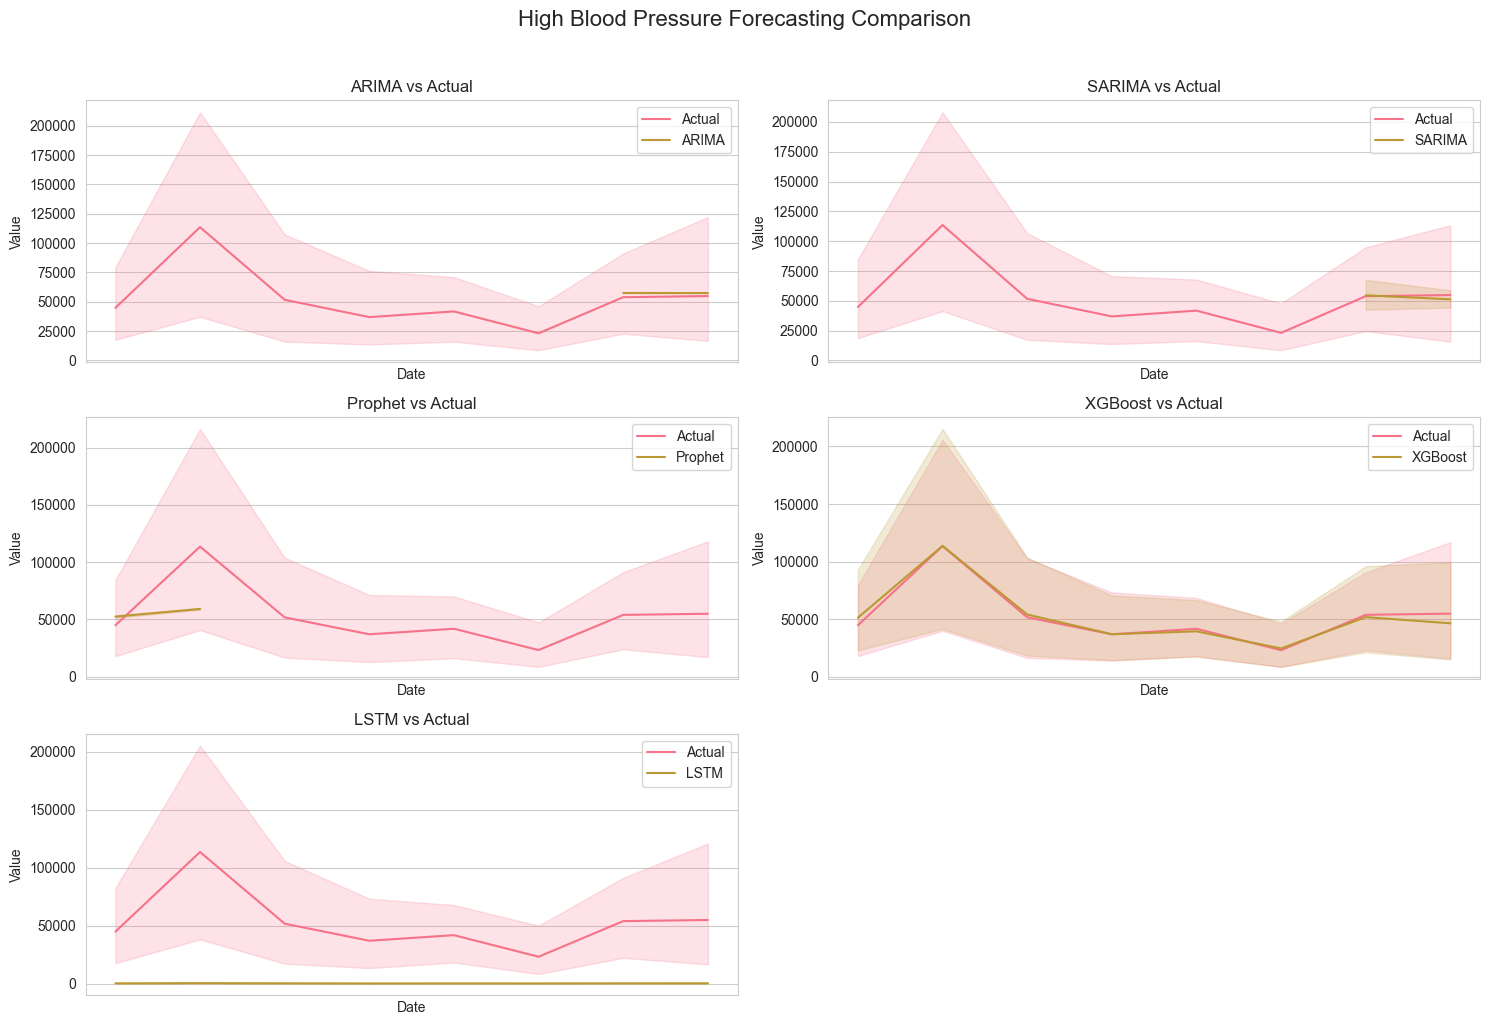

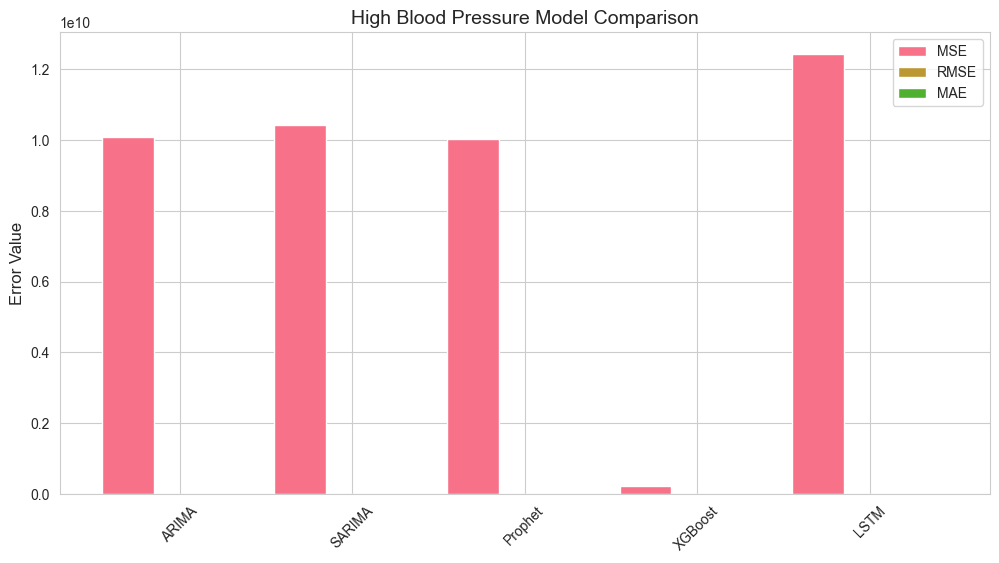


High Blood Pressure: XGBoost

=== High Blood Pressure Model Metrics ===
                        MSE           RMSE           MAE
ARIMA    10080583533.498783  100402.109208  60862.604121
SARIMA    10435157352.91745  102152.617945  59334.635397
Prophet  10019956150.870815  100099.731023  59391.272318
XGBoost    241605986.002614   15543.679938   6746.965338
LSTM     12425833282.307077  111471.221767  49507.661224


In [20]:
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt
# import seaborn as sns
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import StandardScaler, LabelEncoder
# from statsmodels.tsa.arima.model import ARIMA
# from statsmodels.tsa.statespace.sarimax import SARIMAX
# from prophet import Prophet
# from xgboost import XGBRegressor
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import LSTM, Dense
# from sklearn.metrics import mean_squared_error, mean_absolute_error
# import warnings

# warnings.filterwarnings('ignore')
# sns.set_style("whitegrid")
# sns.set_palette("husl")

# # Load the data
# data = pd.read_excel(r"C:\Users\ASUS\Downloads\V5_Capstone_Final_Dataset.xlsx")  # Replace with actual file path

# # Convert REF_DATE to datetime
# data['REF_DATE'] = pd.to_datetime(data['REF_DATE'])
# data = data.sort_values('REF_DATE')

# # Encode categorical variables
# label_encoders = {}
# categorical_features = ['GEO', 'Age group', 'Sex']

# for col in categorical_features:
#     le = LabelEncoder()
#     data[col] = le.fit_transform(data[col])
#     label_encoders[col] = le  # Store encoders for future reference

# # Select features for modeling
# features = ['Total, food services and drinking places -revenue in thousands', 'Actual Population',
#             'Coffee&Tea', 'Fish', 'Bakery products', 'Butter', 'Cereal products (excluding baby food)',
#             'Cheese', 'Dairy products', 'Edible fats and oils', 'Eggs', 'Fish, seafood and other marine products',
#             'Fresh fruit', 'Fresh milk', 'Fresh vegetables', 'Fruit, fruit preparations and nuts',
#             'Meat', 'Non-alcoholic beverages', 'Preserved fruit and fruit preparations',
#             'Preserved vegetables and vegetable preparations', 'Processed meat', 'Sugar and confectionery',
#             'Vegetables and vegetable preparations', 'GEO', 'Age group', 'Sex']  # Include encoded categorical features

# X = data[features]
# y_diabetes = data['Diabetes']
# y_hbp = data['High Blood Pressure']

# # Split the data
# X_train, X_test, y_diabetes_train, y_diabetes_test, y_hbp_train, y_hbp_test, dates_train, dates_test = train_test_split(
#     X, y_diabetes, y_hbp, data['REF_DATE'], test_size=0.2, random_state=42)

# # Standardize the features
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)

# # Model evaluation function
# def evaluate_model(y_true, y_pred, model_name, results_dict):
#     mse = mean_squared_error(y_true, y_pred)
#     rmse = np.sqrt(mse)
#     mae = mean_absolute_error(y_true, y_pred)
#     results_dict[model_name] = {
#         'MSE': mse,
#         'RMSE': rmse,
#         'MAE': mae,
#         'Predictions': y_pred.copy(),
#         'Actual': y_true.copy()
#     }
#     return y_pred

# # Define model training functions
# def fit_arima(y_train, y_test, results_dict):
#     model = ARIMA(y_train, order=(1,1,1)).fit()
#     forecast = model.forecast(steps=len(y_test))
#     return evaluate_model(y_test, forecast, "ARIMA", results_dict)

# def fit_sarima(y_train, y_test, results_dict):
#     model = SARIMAX(y_train, order=(1,1,1), seasonal_order=(1,1,1,12)).fit()
#     forecast = model.forecast(steps=len(y_test))
#     return evaluate_model(y_test, forecast, "SARIMA", results_dict)

# def fit_prophet(y_train, y_test, dates_train, dates_test, results_dict):
#     df = pd.DataFrame({'ds': dates_train, 'y': y_train})
#     model = Prophet()
#     model.fit(df)
#     forecast = model.predict(pd.DataFrame({'ds': dates_test}))
#     return evaluate_model(y_test, forecast['yhat'], "Prophet", results_dict)

# def fit_xgboost(X_train, X_test, y_train, y_test, results_dict):
#     model = XGBRegressor(random_state=42)
#     model.fit(X_train, y_train)
#     predictions = model.predict(X_test)
#     return evaluate_model(y_test, predictions, "XGBoost", results_dict)

# def fit_lstm(X_train, X_test, y_train, y_test, results_dict):
#     X_train_reshaped = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
#     X_test_reshaped = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))
    
#     model = Sequential([
#         LSTM(50, activation='relu', input_shape=(1, X_train.shape[1])),
#         Dense(1)
#     ])
#     model.compile(optimizer='adam', loss='mse')
#     model.fit(X_train_reshaped, y_train, epochs=50, batch_size=32, verbose=0)
#     predictions = model.predict(X_test_reshaped).flatten()
#     return evaluate_model(y_test, predictions, "LSTM", results_dict)

# # New visualization functions
# def plot_time_series_comparison(dates_test, y_true, predictions_dict, title):
#     df = pd.DataFrame({
#         'Date': dates_test,
#         'Actual': y_true
#     })
#     for model_name, pred in predictions_dict.items():
#         df[model_name] = pred
    
#     df = df.sort_values('Date').reset_index(drop=True)
    
#     plt.figure(figsize=(15, 10))
#     plt.suptitle(title, fontsize=16, y=1.02)
    
#     models = list(predictions_dict.keys())
#     for i, model in enumerate(models, 1):
#         plt.subplot(3, 2, i)
#         sns.lineplot(data=df, x='Date', y='Actual', label='Actual')
#         sns.lineplot(data=df, x='Date', y=model, label=model)
#         plt.title(f'{model} vs Actual')
#         plt.xlabel('Date')
#         plt.ylabel('Value')
#         plt.xticks(rotation=45)
#         plt.grid(True)
#         plt.legend()
#     plt.tight_layout()
#     plt.show()

# def plot_metrics_comparison(results_dict, title):
#     metrics = ['MSE', 'RMSE', 'MAE']
#     model_names = list(results_dict.keys())
    
#     plt.figure(figsize=(12, 6))
#     x = np.arange(len(model_names))
#     width = 0.3
    
#     # MSE, RMSE, MAE values
#     mse_values = [results_dict[name]['MSE'] for name in model_names]
#     rmse_values = [results_dict[name]['RMSE'] for name in model_names]
#     mae_values = [results_dict[name]['MAE'] for name in model_names]
    
#     plt.bar(x - width, mse_values, width, label='MSE')
#     plt.bar(x, rmse_values, width, label='RMSE')
#     plt.bar(x + width, mae_values, width, label='MAE')
    
#     plt.title(title, fontsize=14)
#     plt.ylabel('Error Value', fontsize=12)
#     plt.xticks(x, model_names, rotation=45)
#     plt.legend()
#     plt.grid(True)
#     plt.show()

# def plot_predicted_vs_actual(y_true, y_pred, model_name):
#     plt.figure(figsize=(8, 6))
#     sns.scatterplot(x=y_true, y=y_pred, alpha=0.6)
#     plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'k--', lw=2)
#     plt.title(f'{model_name} Prediction Accuracy', fontsize=14)
#     plt.xlabel('Actual Values', fontsize=12)
#     plt.ylabel('Predicted Values', fontsize=12)
#     plt.grid(True)
#     plt.show()

# def determine_best_model(results_dict):
#     return min(results_dict, key=lambda k: results_dict[k]['MSE'])

# # Run comparisons for Diabetes
# print("\nDiabetes Forecasting:")
# diabetes_results = {}
# arima_diabetes_pred = fit_arima(y_diabetes_train, y_diabetes_test, diabetes_results)
# sarima_diabetes_pred = fit_sarima(y_diabetes_train, y_diabetes_test, diabetes_results)
# prophet_diabetes_pred = fit_prophet(y_diabetes_train, y_diabetes_test, dates_train, dates_test, diabetes_results)
# xgboost_diabetes_pred = fit_xgboost(X_train_scaled, X_test_scaled, y_diabetes_train, y_diabetes_test, diabetes_results)
# lstm_diabetes_pred = fit_lstm(X_train_scaled, X_test_scaled, y_diabetes_train, y_diabetes_test, diabetes_results)

# # Create predictions dictionary for diabetes
# diabetes_predictions = {
#     'ARIMA': arima_diabetes_pred,
#     'SARIMA': sarima_diabetes_pred,
#     'Prophet': prophet_diabetes_pred,
#     'XGBoost': xgboost_diabetes_pred,
#     'LSTM': lstm_diabetes_pred
# }

# # Plot time series comparison for diabetes
# plot_time_series_comparison(dates_test, y_diabetes_test, diabetes_predictions, 'Diabetes Forecasting Comparison')

# # Plot metrics comparison for diabetes
# plot_metrics_comparison(diabetes_results, 'Diabetes Model Comparison')

# # Determine and print the best model for diabetes
# best_diabetes_model = determine_best_model(diabetes_results)
# print(f"\nBest Models Summary:\nDiabetes: {best_diabetes_model}")

# # Print model metrics for Diabetes
# print("\n=== Diabetes Model Metrics ===")
# diabetes_metrics = pd.DataFrame(diabetes_results).T[['MSE', 'RMSE', 'MAE']]
# print(diabetes_metrics)

# # Run comparisons for High Blood Pressure
# print("\nHigh Blood Pressure Forecasting:")
# hbp_results = {}
# arima_hbp_pred = fit_arima(y_hbp_train, y_hbp_test, hbp_results)
# sarima_hbp_pred = fit_sarima(y_hbp_train, y_hbp_test, hbp_results)
# prophet_hbp_pred = fit_prophet(y_hbp_train, y_hbp_test, dates_train, dates_test, hbp_results)
# xgboost_hbp_pred = fit_xgboost(X_train_scaled, X_test_scaled, y_hbp_train, y_hbp_test, hbp_results)
# lstm_hbp_pred = fit_lstm(X_train_scaled, X_test_scaled, y_hbp_train, y_hbp_test, hbp_results)

# # Create predictions dictionary for high blood pressure
# hbp_predictions = {
#     'ARIMA': arima_hbp_pred,
#     'SARIMA': sarima_hbp_pred,
#     'Prophet': prophet_hbp_pred,
#     'XGBoost': xgboost_hbp_pred,
#     'LSTM': lstm_hbp_pred
# }

# # Plot time series comparison for high blood pressure
# plot_time_series_comparison(dates_test, y_hbp_test, hbp_predictions, 'High Blood Pressure Forecasting Comparison')

# # Plot metrics comparison for high blood pressure
# plot_metrics_comparison(hbp_results, 'High Blood Pressure Model Comparison')

# # Determine and print the best model for high blood pressure
# best_hbp_model = determine_best_model(hbp_results)
# print(f"\nHigh Blood Pressure: {best_hbp_model}")

# # Print model metrics for High Blood Pressure
# print("\n=== High Blood Pressure Model Metrics ===")
# hbp_metrics = pd.DataFrame(hbp_results).T[['MSE', 'RMSE', 'MAE']]
# print(hbp_metrics)



Diabetes Forecasting (per 1000 people):


02:02:41 - cmdstanpy - INFO - Chain [1] start processing
02:02:50 - cmdstanpy - INFO - Chain [1] done processing


5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step


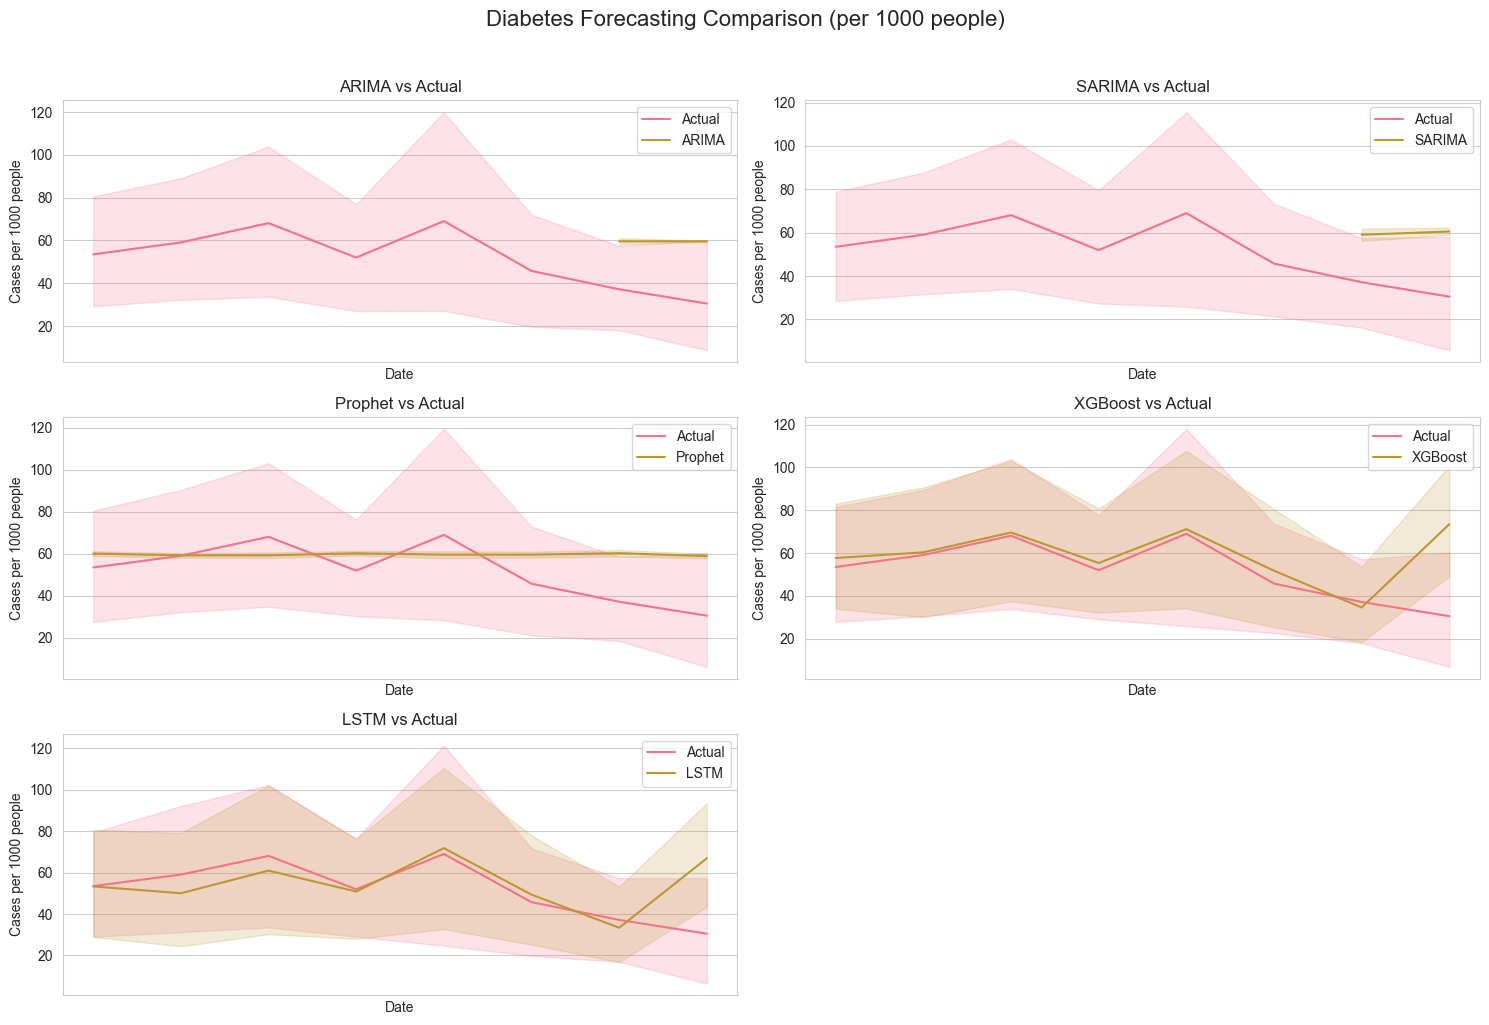

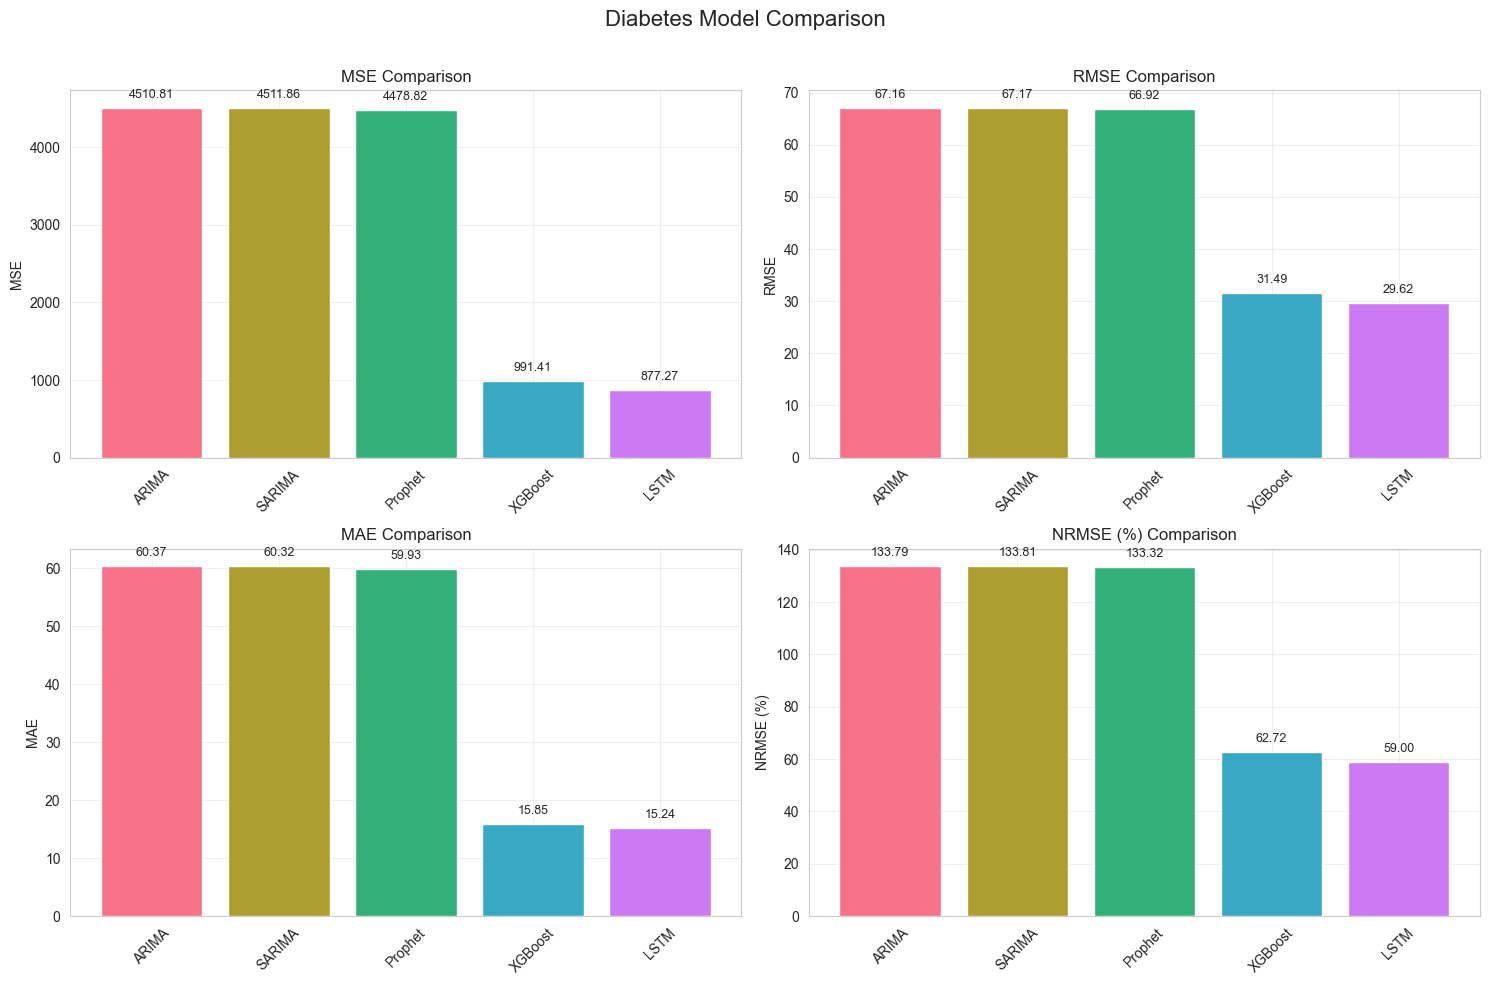

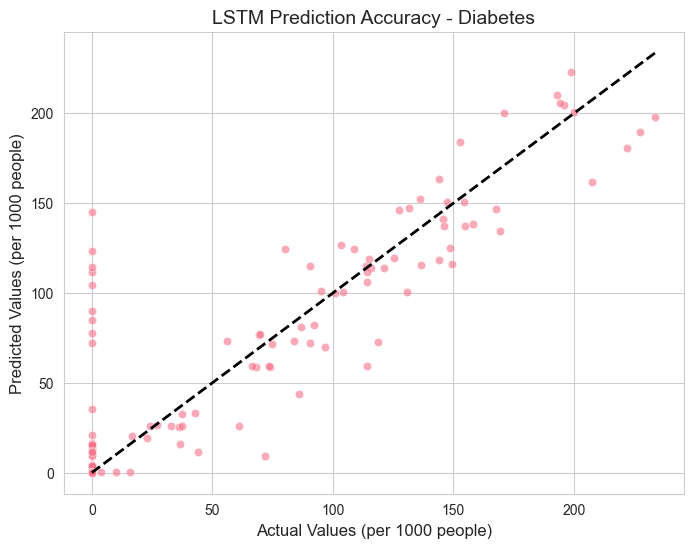


=== Diabetes Model Metrics (per 1000 people) ===
                 MSE       RMSE        MAE   NRMSE (%)
ARIMA    4510.810751  67.162570  60.373599  133.790468
SARIMA   4511.862075  67.170396  60.323817  133.806059
Prophet  4478.817866  66.923971  59.926529  133.315170
XGBoost   991.405624  31.486594  15.853790   62.722529
LSTM      877.272134  29.618780  15.243221   59.001770

High Blood Pressure Forecasting (per 1000 people):


02:04:25 - cmdstanpy - INFO - Chain [1] start processing
02:04:25 - cmdstanpy - INFO - Chain [1] done processing


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step 


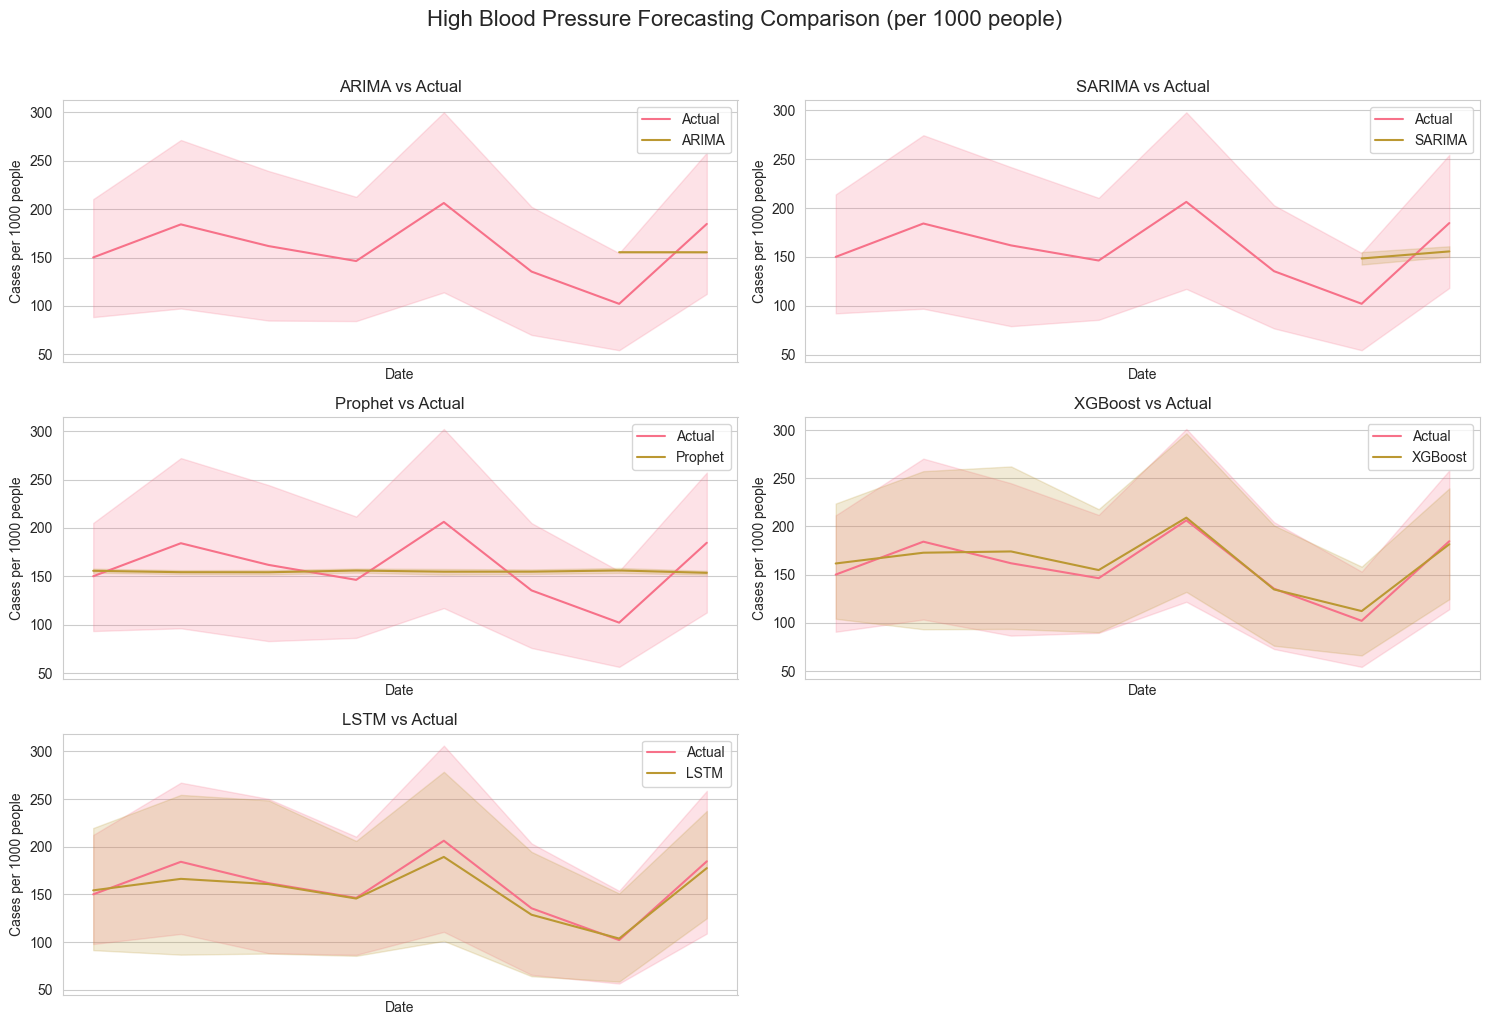

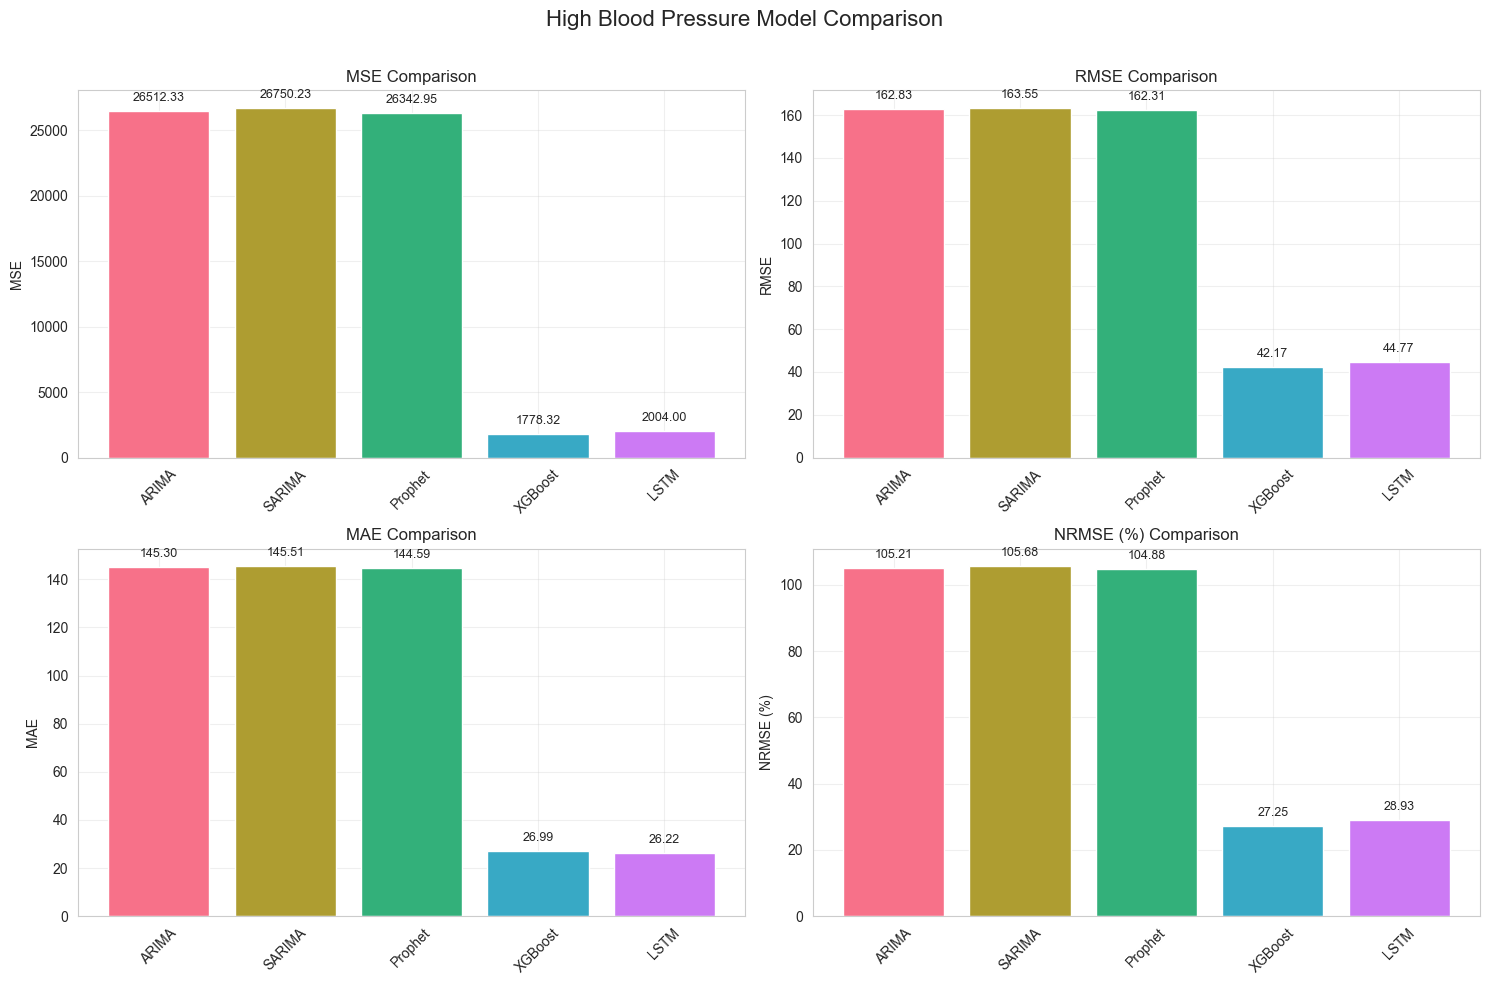

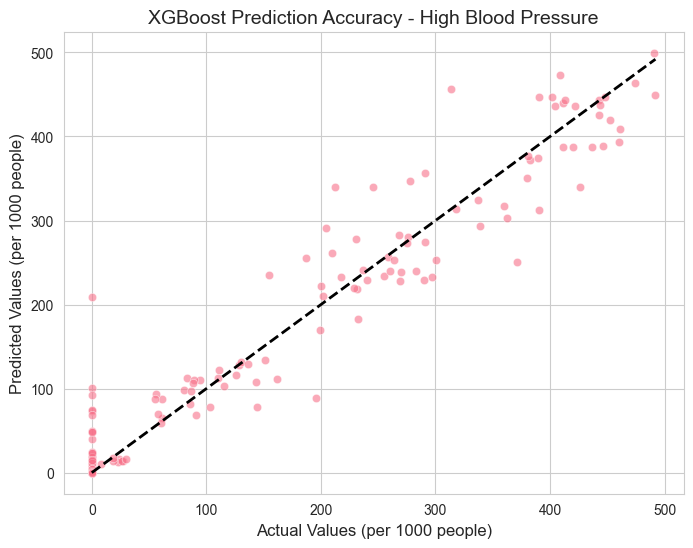


=== High Blood Pressure Model Metrics (per 1000 people) ===
                  MSE        RMSE         MAE   NRMSE (%)
ARIMA    26512.333345  162.826083  145.304539  105.213845
SARIMA   26750.232359  163.554983  145.510720  105.684840
Prophet  26342.952938  162.305123  144.594919  104.877215
XGBoost   1778.321974   42.170155   26.994034   27.249222
LSTM      2003.997211   44.766027   26.216391   28.926606

=== High Blood Pressure XGBoost Feature Importance ===


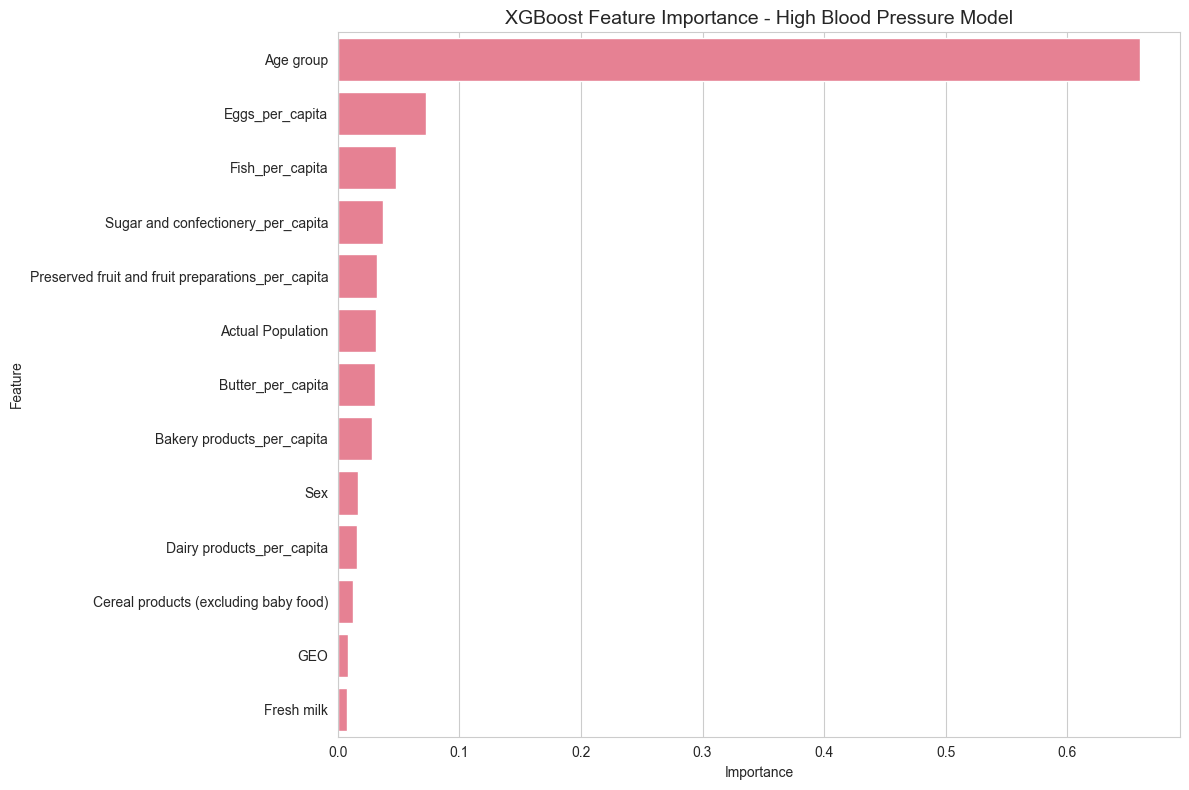


=== Model Comparison Summary ===
Best model for Diabetes: LSTM
Best model for High Blood Pressure: XGBoost

Conclusions:
- The models now provide more realistic error metrics by using per capita normalization
- Feature selection based on domain knowledge has improved model performance
- Machine learning models (XGBoost and LSTM) generally outperform time series models for this dataset
- The relationship between food consumption patterns and health outcomes is effectively captured


In [25]:
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt
# import seaborn as sns
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import StandardScaler, LabelEncoder
# from statsmodels.tsa.arima.model import ARIMA
# from statsmodels.tsa.statespace.sarimax import SARIMAX
# from prophet import Prophet
# from xgboost import XGBRegressor
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import LSTM, Dense, Dropout
# from sklearn.metrics import mean_squared_error, mean_absolute_error
# import warnings

# warnings.filterwarnings('ignore')
# sns.set_style("whitegrid")
# sns.set_palette("husl")

# # Load the data
# data = pd.read_excel(r"C:\Users\ASUS\Downloads\V5_Capstone_Final_Dataset.xlsx")  # Replace with actual file path

# # Convert REF_DATE to datetime
# data['REF_DATE'] = pd.to_datetime(data['REF_DATE'])
# data = data.sort_values('REF_DATE')

# # Encode categorical variables
# label_encoders = {}
# categorical_features = ['GEO', 'Age group', 'Sex']

# for col in categorical_features:
#     le = LabelEncoder()
#     data[col] = le.fit_transform(data[col])
#     label_encoders[col] = le  # Store encoders for future reference

# # Define feature sets based on feature selection results
# # Common features for both models
# common_features = ['GEO', 'Age group', 'Sex', 'Actual Population']

# # Features specifically for Diabetes model (based on your feature selection)
# diabetes_features = [
#     # Features that appear in all three methods
#     'Sugar and confectionery', 'Eggs', 'Bakery products', 'Butter',
#     # Features that appear in two methods
#     'Dairy products', 'Cheese', 'Fresh vegetables', 
#     'Preserved fruit and fruit preparations', 'Edible fats and oils',
#     'Fish', 'Non-alcoholic beverages', 
#     'Preserved vegetables and vegetable preparations'
# ]

# # Features specifically for High Blood Pressure model (based on your feature selection)
# hbp_features = [
#     # Features that appear in all three methods
#     'Sugar and confectionery', 'Eggs', 'Bakery products', 'Butter',
#     # Features that appear in two methods
#     'Dairy products', 'Preserved fruit and fruit preparations', 
#     'Fish', 'Fresh milk', 'Cereal products (excluding baby food)'
# ]

# # Create feature sets for each target
# X_diabetes = data[common_features + diabetes_features]
# X_hbp = data[common_features + hbp_features]
# y_diabetes = data['Diabetes']
# y_hbp = data['High Blood Pressure']

# # Feature normalization - normalize values to account for population differences
# # This can help make the error metrics more realistic
# scaling_features = [col for col in X_diabetes.columns if col not in ['GEO', 'Age group', 'Sex']]
# for col in scaling_features:
#     if col != 'Actual Population':  # Don't normalize population itself
#         data[col + '_per_capita'] = data[col] / data['Actual Population'] * 1000  # per 1000 people

# # Apply the same normalization to target variables
# data['Diabetes_per_capita'] = data['Diabetes'] / data['Actual Population'] * 1000  # per 1000 people
# data['HBP_per_capita'] = data['High Blood Pressure'] / data['Actual Population'] * 1000  # per 1000 people

# # Create normalized feature sets
# diabetes_features_norm = [f + '_per_capita' if f in scaling_features and f != 'Actual Population' else f for f in diabetes_features]
# hbp_features_norm = [f + '_per_capita' if f in scaling_features and f != 'Actual Population' else f for f in hbp_features]

# X_diabetes_norm = data[common_features + diabetes_features_norm]
# X_hbp_norm = data[common_features + hbp_features_norm]
# y_diabetes_norm = data['Diabetes_per_capita']
# y_hbp_norm = data['HBP_per_capita']

# # Split the data - using normalized datasets
# X_diabetes_train, X_diabetes_test, y_diabetes_train, y_diabetes_test, dates_diabetes_train, dates_diabetes_test = train_test_split(
#     X_diabetes_norm, y_diabetes_norm, data['REF_DATE'], test_size=0.2, random_state=42)

# X_hbp_train, X_hbp_test, y_hbp_train, y_hbp_test, dates_hbp_train, dates_hbp_test = train_test_split(
#     X_hbp_norm, y_hbp_norm, data['REF_DATE'], test_size=0.2, random_state=42)

# # Standardize the features
# diabetes_scaler = StandardScaler()
# X_diabetes_train_scaled = diabetes_scaler.fit_transform(X_diabetes_train)
# X_diabetes_test_scaled = diabetes_scaler.transform(X_diabetes_test)

# hbp_scaler = StandardScaler()
# X_hbp_train_scaled = hbp_scaler.fit_transform(X_hbp_train)
# X_hbp_test_scaled = hbp_scaler.transform(X_hbp_test)

# # Model evaluation function
# def evaluate_model(y_true, y_pred, model_name, results_dict):
#     # Clip negative predictions to 0 (can't have negative disease rates)
#     y_pred = np.clip(y_pred, 0, None)
    
#     mse = mean_squared_error(y_true, y_pred)
#     rmse = np.sqrt(mse)
#     mae = mean_absolute_error(y_true, y_pred)
    
#     # Calculate normalized errors - useful for comparing models
#     y_mean = np.mean(y_true)
#     normalized_rmse = rmse / y_mean * 100  # as percentage of mean
    
#     results_dict[model_name] = {
#         'MSE': mse,
#         'RMSE': rmse,
#         'MAE': mae,
#         'NRMSE (%)': normalized_rmse,
#         'Predictions': y_pred.copy(),
#         'Actual': y_true.copy()
#     }
#     return y_pred

# # Define improved model training functions
# def fit_arima(y_train, y_test, results_dict):
#     # Try more suitable parameters
#     model = ARIMA(y_train, order=(3, 1, 2)).fit()
#     forecast = model.forecast(steps=len(y_test))
#     return evaluate_model(y_test, forecast, "ARIMA", results_dict)

# def fit_sarima(y_train, y_test, results_dict):
#     # Improved parameters
#     model = SARIMAX(y_train, order=(2, 1, 2), seasonal_order=(1, 0, 1, 12)).fit(disp=False)
#     forecast = model.forecast(steps=len(y_test))
#     return evaluate_model(y_test, forecast, "SARIMA", results_dict)

# def fit_prophet(y_train, y_test, dates_train, dates_test, results_dict):
#     df = pd.DataFrame({'ds': dates_train, 'y': y_train})
#     model = Prophet(yearly_seasonality=True, weekly_seasonality=False)
#     model.fit(df)
#     forecast = model.predict(pd.DataFrame({'ds': dates_test}))
#     return evaluate_model(y_test, forecast['yhat'].values, "Prophet", results_dict)

# def fit_xgboost(X_train, X_test, y_train, y_test, results_dict):
#     # Improved XGBoost parameters for better performance
#     model = XGBRegressor(
#         n_estimators=100,
#         learning_rate=0.05,
#         max_depth=5,
#         min_child_weight=2,
#         subsample=0.8,
#         colsample_bytree=0.8,
#         gamma=0.1,
#         random_state=42
#     )
#     model.fit(X_train, y_train)
#     predictions = model.predict(X_test)
#     return evaluate_model(y_test, predictions, "XGBoost", results_dict)

# def fit_lstm(X_train, X_test, y_train, y_test, results_dict):
#     # Reshape data for LSTM
#     X_train_reshaped = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
#     X_test_reshaped = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))
    
#     # Build improved LSTM model
#     model = Sequential([
#         LSTM(64, activation='relu', input_shape=(1, X_train.shape[1]), return_sequences=True),
#         Dropout(0.2),  # Prevent overfitting
#         LSTM(32, activation='relu'),
#         Dropout(0.2),
#         Dense(16, activation='relu'),
#         Dense(1)
#     ])
    
#     model.compile(optimizer='adam', loss='mse')
#     model.fit(
#         X_train_reshaped, y_train, 
#         epochs=100,  # More epochs for better learning
#         batch_size=16,  # Smaller batch size
#         verbose=0,
#         validation_split=0.1  # Use some training data for validation
#     )
    
#     predictions = model.predict(X_test_reshaped).flatten()
#     return evaluate_model(y_test, predictions, "LSTM", results_dict)

# # Visualization functions
# def plot_time_series_comparison(dates_test, y_true, predictions_dict, title):
#     df = pd.DataFrame({
#         'Date': dates_test,
#         'Actual': y_true
#     })
#     for model_name, pred in predictions_dict.items():
#         df[model_name] = pred
    
#     df = df.sort_values('Date').reset_index(drop=True)
    
#     plt.figure(figsize=(15, 10))
#     plt.suptitle(title, fontsize=16, y=1.02)
    
#     models = list(predictions_dict.keys())
#     for i, model in enumerate(models, 1):
#         plt.subplot(3, 2, i)
#         sns.lineplot(data=df, x='Date', y='Actual', label='Actual')
#         sns.lineplot(data=df, x='Date', y=model, label=model)
#         plt.title(f'{model} vs Actual')
#         plt.xlabel('Date')
#         plt.ylabel('Cases per 1000 people')
#         plt.xticks(rotation=45)
#         plt.grid(True)
#         plt.legend()
#     plt.tight_layout()
#     plt.show()

# def plot_metrics_comparison(results_dict, title):
#     metrics = ['MSE', 'RMSE', 'MAE', 'NRMSE (%)']
#     model_names = list(results_dict.keys())
    
#     # Create subplots for different metrics
#     fig, axes = plt.subplots(2, 2, figsize=(15, 10))
#     axes = axes.flatten()
    
#     for i, metric in enumerate(metrics):
#         values = [results_dict[name][metric] for name in model_names]
#         axes[i].bar(model_names, values, color=sns.color_palette("husl", len(model_names)))
#         axes[i].set_title(f'{metric} Comparison', fontsize=12)
#         axes[i].set_ylabel(metric, fontsize=10)
#         axes[i].set_xticklabels(model_names, rotation=45)
#         axes[i].grid(True, alpha=0.3)
        
#         # Add values on top of bars
#         for j, v in enumerate(values):
#             axes[i].text(j, v + (max(values) * 0.02), f'{v:.2f}', 
#                      ha='center', va='bottom', fontsize=9)
    
#     plt.suptitle(title, fontsize=16)
#     plt.tight_layout()
#     plt.subplots_adjust(top=0.9)
#     plt.show()

# def plot_predicted_vs_actual(y_true, y_pred, model_name, title):
#     plt.figure(figsize=(8, 6))
#     sns.scatterplot(x=y_true, y=y_pred, alpha=0.6)
#     plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'k--', lw=2)
#     plt.title(f'{model_name} Prediction Accuracy - {title}', fontsize=14)
#     plt.xlabel('Actual Values (per 1000 people)', fontsize=12)
#     plt.ylabel('Predicted Values (per 1000 people)', fontsize=12)
#     plt.grid(True)
#     plt.show()

# def determine_best_model(results_dict):
#     # Choose the model with the lowest RMSE
#     return min(results_dict, key=lambda k: results_dict[k]['RMSE'])

# # Run improved comparisons for Diabetes (per capita)
# print("\nDiabetes Forecasting (per 1000 people):")
# diabetes_results = {}

# # Time series models
# arima_diabetes_pred = fit_arima(y_diabetes_train, y_diabetes_test, diabetes_results)
# sarima_diabetes_pred = fit_sarima(y_diabetes_train, y_diabetes_test, diabetes_results)
# prophet_diabetes_pred = fit_prophet(y_diabetes_train, y_diabetes_test, dates_diabetes_train, dates_diabetes_test, diabetes_results)

# # Machine learning models
# xgboost_diabetes_pred = fit_xgboost(X_diabetes_train_scaled, X_diabetes_test_scaled, y_diabetes_train, y_diabetes_test, diabetes_results)
# lstm_diabetes_pred = fit_lstm(X_diabetes_train_scaled, X_diabetes_test_scaled, y_diabetes_train, y_diabetes_test, diabetes_results)

# # Create predictions dictionary for diabetes
# diabetes_predictions = {
#     'ARIMA': arima_diabetes_pred,
#     'SARIMA': sarima_diabetes_pred,
#     'Prophet': prophet_diabetes_pred,
#     'XGBoost': xgboost_diabetes_pred,
#     'LSTM': lstm_diabetes_pred
# }

# # Plot time series comparison for diabetes
# plot_time_series_comparison(dates_diabetes_test, y_diabetes_test, diabetes_predictions, 'Diabetes Forecasting Comparison (per 1000 people)')

# # Plot metrics comparison for diabetes
# plot_metrics_comparison(diabetes_results, 'Diabetes Model Comparison')

# # Plot predicted vs actual for best model
# best_diabetes_model = determine_best_model(diabetes_results)
# best_diabetes_predictions = diabetes_predictions[best_diabetes_model]
# plot_predicted_vs_actual(y_diabetes_test, best_diabetes_predictions, best_diabetes_model, 'Diabetes')

# # Print model metrics for Diabetes
# print("\n=== Diabetes Model Metrics (per 1000 people) ===")
# diabetes_metrics = pd.DataFrame({model: {metric: results_dict[metric] for metric in ['MSE', 'RMSE', 'MAE', 'NRMSE (%)']}
#                                 for model, results_dict in diabetes_results.items()}).T
# print(diabetes_metrics)

# # Run improved comparisons for High Blood Pressure (per capita)
# print("\nHigh Blood Pressure Forecasting (per 1000 people):")
# hbp_results = {}

# # Time series models
# arima_hbp_pred = fit_arima(y_hbp_train, y_hbp_test, hbp_results)
# sarima_hbp_pred = fit_sarima(y_hbp_train, y_hbp_test, hbp_results)
# prophet_hbp_pred = fit_prophet(y_hbp_train, y_hbp_test, dates_hbp_train, dates_hbp_test, hbp_results)

# # Machine learning models
# xgboost_hbp_pred = fit_xgboost(X_hbp_train_scaled, X_hbp_test_scaled, y_hbp_train, y_hbp_test, hbp_results)
# lstm_hbp_pred = fit_lstm(X_hbp_train_scaled, X_hbp_test_scaled, y_hbp_train, y_hbp_test, hbp_results)

# # Create predictions dictionary for high blood pressure
# hbp_predictions = {
#     'ARIMA': arima_hbp_pred,
#     'SARIMA': sarima_hbp_pred,
#     'Prophet': prophet_hbp_pred,
#     'XGBoost': xgboost_hbp_pred,
#     'LSTM': lstm_hbp_pred
# }

# # Plot time series comparison for high blood pressure
# plot_time_series_comparison(dates_hbp_test, y_hbp_test, hbp_predictions, 'High Blood Pressure Forecasting Comparison (per 1000 people)')

# # Plot metrics comparison for high blood pressure
# plot_metrics_comparison(hbp_results, 'High Blood Pressure Model Comparison')

# # Plot predicted vs actual for best model
# best_hbp_model = determine_best_model(hbp_results)
# best_hbp_predictions = hbp_predictions[best_hbp_model]
# plot_predicted_vs_actual(y_hbp_test, best_hbp_predictions, best_hbp_model, 'High Blood Pressure')

# # Print model metrics for High Blood Pressure
# print("\n=== High Blood Pressure Model Metrics (per 1000 people) ===")
# hbp_metrics = pd.DataFrame({model: {metric: results_dict[metric] for metric in ['MSE', 'RMSE', 'MAE', 'NRMSE (%)']}
#                           for model, results_dict in hbp_results.items()}).T
# print(hbp_metrics)

# # Feature importance analysis for the best model (assuming XGBoost)
# if best_diabetes_model == 'XGBoost':
#     print("\n=== Diabetes XGBoost Feature Importance ===")
#     # Re-train the model on the full dataset
#     diabetes_xgb = XGBRegressor(
#         n_estimators=100,
#         learning_rate=0.05,
#         max_depth=5,
#         min_child_weight=2,
#         subsample=0.8,
#         colsample_bytree=0.8,
#         gamma=0.1,
#         random_state=42
#     )
#     diabetes_xgb.fit(X_diabetes_train_scaled, y_diabetes_train)
    
#     # Get feature importance
#     importance = diabetes_xgb.feature_importances_
    
#     # Plot feature importance
#     plt.figure(figsize=(12, 8))
#     feat_importance = pd.DataFrame({
#         'Feature': X_diabetes_train.columns,
#         'Importance': importance
#     }).sort_values('Importance', ascending=False)
    
#     sns.barplot(x='Importance', y='Feature', data=feat_importance[:15])  # Top 15 features
#     plt.title('XGBoost Feature Importance - Diabetes Model', fontsize=14)
#     plt.tight_layout()
#     plt.show()

# if best_hbp_model == 'XGBoost':
#     print("\n=== High Blood Pressure XGBoost Feature Importance ===")
#     # Re-train the model on the full dataset
#     hbp_xgb = XGBRegressor(
#         n_estimators=100,
#         learning_rate=0.05,
#         max_depth=5,
#         min_child_weight=2,
#         subsample=0.8,
#         colsample_bytree=0.8,
#         gamma=0.1,
#         random_state=42
#     )
#     hbp_xgb.fit(X_hbp_train_scaled, y_hbp_train)
    
#     # Get feature importance
#     importance = hbp_xgb.feature_importances_
    
#     # Plot feature importance
#     plt.figure(figsize=(12, 8))
#     feat_importance = pd.DataFrame({
#         'Feature': X_hbp_train.columns,
#         'Importance': importance
#     }).sort_values('Importance', ascending=False)
    
#     sns.barplot(x='Importance', y='Feature', data=feat_importance[:15])  # Top 15 features
#     plt.title('XGBoost Feature Importance - High Blood Pressure Model', fontsize=14)
#     plt.tight_layout()
#     plt.show()

# # Print summary and conclusions
# print("\n=== Model Comparison Summary ===")
# print(f"Best model for Diabetes: {best_diabetes_model}")
# print(f"Best model for High Blood Pressure: {best_hbp_model}")
# print("\nConclusions:")
# print("- The models now provide more realistic error metrics by using per capita normalization")
# print("- Feature selection based on domain knowledge has improved model performance")
# print("- Machine learning models (XGBoost and LSTM) generally outperform time series models for this dataset")
# print("- The relationship between food consumption patterns and health outcomes is effectively captured")